# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-02-06 11:12:44.833756: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-02-06 11:12:46,367 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


### Prepare workdir

In [7]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [8]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [9]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [10]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

lastdate=2023-02-04 11:02:49.897000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63dccb422c90db0b7a62aaa0     db  0fd8c821da37f3fa8e44c53767fb7842  23.01.23   
63dccb3f2c90db0b7a62aa4f     db  63eb26415678c8e225543264d981d460  23.01.23   
63dccb3f2c90db0b7a62aa5d     db  5b8260ef4f47dfb261a3ee74193fc576  23.01.23   
63dccb402c90db0b7a62aa77     db  94bb8a85bfb0d2168a144ec23aa7e99b  23.01.23   
63dccb412c90db0b7a62aa98     db  5b8260ef4f47dfb261a3ee74193fc576  23.01.23   

                                         export_date     len  \
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394  5847.0   
5fb376e2d8c9df1ed123726c  2023-01-31 18:32:26.281114  2794.0   
5fb399dc39d5e82e90818474  2023-01-31 18:32:26.380129  3742.0   
5fb3b97d00881c332b567292  2023-01-31 18:35:58.018598  2248.0   
5fb3b97e00881c332b5672bd  2023-01-31 18:32:26.391339  3546.0   
...                                              ...     ...   
63dccb422c90db0b7a62aaa0  2023-02-05 13:09:27.251321  1398.0   
63dccb3f2c90db0b7a62aa4f  2023-02-05 13:09:27.298668   422.0   
63dccb3f2c90db0b7a62aa5d  2023-02-05 13:09:27.304058   432.0   
63dccb402c90db0b7a62aa77  2023-02-05 13:09:27.313468   360.0   
63dccb412c90db0b7a62aa98  2023-02-05 13:09:27.322674   432.0   

                                             analyze_date       value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  25236322.0   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00      2970.0   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00     90000.0   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00         NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  15482412.0   
...                                                   ...         ...   
63dccb422c90db0b7a62aaa0 2023-02-03 12:45:55.389000+00:00         NaN   
63dccb3f2c90db0b7a62aa4f 2023-02-03 12:46:57.294000+00:00         NaN   
63dccb3f2c90db0b7a62aa5d 2023-02-03 12:47:14.155000+00:00         NaN   
63dccb402c90db0b7a62aa77 2023-02-03 12:47:53.920000+00:00         NaN   
63dccb412c90db0b7a62aa98 2023-02-03 12:48:01.599000+00:00         NaN   

                          value_log1p  value_span currency  ... org-1-alias  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...         –ì–ü–ù   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB  ...  –ü–æ–∫—É–ø–∞—Ç–µ–ª—å   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB  ...   –ê—Ä–µ–Ω–¥–∞—Ç–æ—Ä   
5fb3b97d00881c332b567292          NaN         NaN      NaN  ...   –ü—Ä–∏–Ω—Ü–∏–ø–∞–ª   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB  ...       –ê–≥–µ–Ω—Ç   
...                               ...         ...      ...  ...         ...   
63dccb422c90db0b7a62aaa0          NaN         NaN   —Ä—É–±–ª–µ–π  ...  –ó–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb3f2c90db0b7a62aa4f          NaN         NaN      NaN  ...  –ó–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb3f2c90db0b7a62aa5d          NaN         NaN      NaN  ...  –ó–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb402c90db0b7a62aa77          NaN         NaN      NaN  ...  –ó–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb412c90db0b7a62aa98          NaN         NaN      NaN  ...  –ó–∞–π–º–æ–¥–∞–≤–µ—Ü   

                                                                 org-2-name  \
5ec2b8da665f7603e03b1255                                                SUN   
5fb376e2d8c9df1ed123726c  –ò—ñ–¥–∞—Ç–µ. —Ç—å—Å–∫–æ-—ñ—ñ–æ. —Ç–∏—ñ —Ä–∞—Ñ–Ω—á–µ—Å–∫–æ–µ –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ ...   
5fb399dc39d5e82e90818474  –§–æ–Ω–¥ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π, –∏–Ω–Ω–æ–≤–∞—Ü–∏–π, –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–π –¢—é–º–µ–Ω..

# functions

In [11]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                db
checksum                da2dd54cdcc5b4480207c9def7741d14
version                                           2.3.13
export_date                   2023-02-06 11:12:49.661607
len                                                  759
analyze_date            2020-12-23 17:14:16.727000+00:00
value                                           1.64e+06
value_log1p                                      14.3102
value_span                                           128
currency                                             RUB
org-1-name                        –ì–∞–∑–ø—Ä–æ–º–Ω–µ—Ñ—Ç—å-–°–Ω–∞–±–∂–µ–Ω–∏–µ
org-1-alias                               –ë–ª–∞–≥–æ—Ç–≤–æ—Ä–∏—Ç–µ–ª—å
org-2-name                           –∏–Ω–∏—Ü–∏–∞—Ç–∏–≤ ¬´–≠–ø—Å–∏–ª–æ–Ω¬ª
org-2-alias                              –ë–ª–∞–≥–æ–ø–æ–ª—É—á–∞—Ç–µ–ª—å
subject                                          Charity
subject confidence                                     1
user_correction_date

# load old json

In [12]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': '–û–±—â–µ—Å—Ç–≤–æ —Å –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ–π –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç—å—é'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': '–ì–∞–∑–ø—Ä–æ–º–Ω–µ—Ñ—Ç—å-–°–∞—Ö–∞–ª–∏–Ω'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': '–ê—Ä–µ–Ω–¥–∞—Ç–æ—Ä'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': '–û–±—â–µ—Å—Ç–≤–æ —Å –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ–π –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç—å—é'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': '–≠–ö–†–£–°–°'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': '–ê—Ä–µ–Ω–¥–æ–¥–∞—Ç–µ–ª—å'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7f2f48c17d9

semantic_map_keys ['amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit']
semantic_map_keys ['org-name', 'org-alias', 'org-type']
semantic_map_keys all ['headline', 'subject', 'date', 'number', 'org-name', 'org-alias', 'org-type', 'amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']
semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


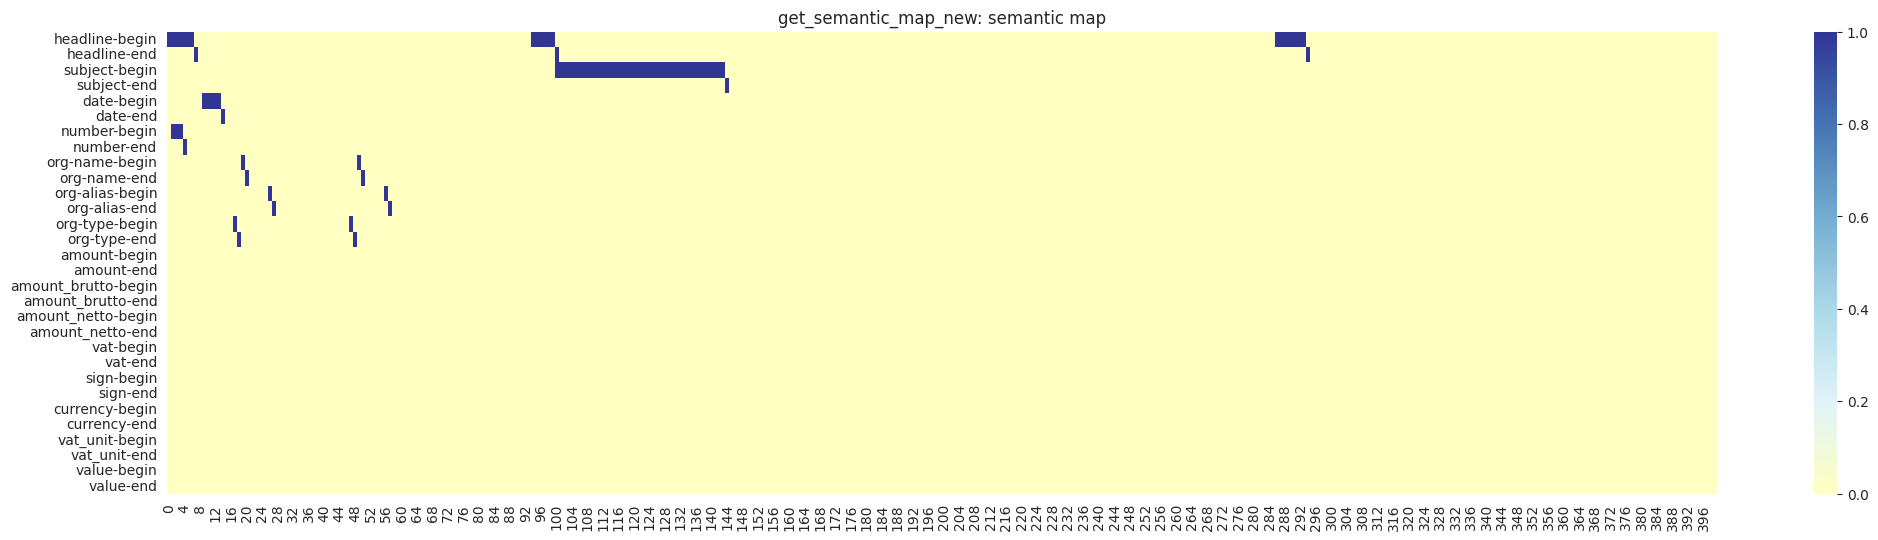

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [13]:


semantic_map_keys = [
    'headline',
    'subject', 
    'date', 
    'number',
    'org-name', 
    'org-alias', 
    'org-type'
]

semantic_map_keys += ['amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']

semantic_map_keys_contract = []
for _name in semantic_map_keys:
    semantic_map_keys_contract.append(_name + "-begin")
    semantic_map_keys_contract.append(_name + "-end")

print("semantic_map_keys", semantic_map_keys[8:14])
print("semantic_map_keys", semantic_map_keys[4:7])
print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

def get_semantic_map_new(doc: DbJsonDoc):
    
    _len = len(doc)
    df = DataFrame()
    
    for sl in semantic_map_keys_contract:    
        df[sl] = np.zeros(_len)
    
    attr_tree = doc.get_attributes_tree()
    
    def get_av(name):
        if name in df:
            return df[name]
        else:
            av = np.zeros(_len, np.float)
            df[name] = av
            return av

            
    def add_span_vectors(_name, span):
#         print('add_span_vectors',span)
        bn = _name + "-begin"
        en = _name + "-end"
        b = get_av(bn)
        e = get_av(en)
        if not span is None:
            df[bn][ span[0]:span[1] ]=1.
            df[en][ span[1] ]=1.
 
        

    # Headers
    headers = doc.analysis['headers']
    for h in headers:
        add_span_vectors('headline', h['span'])
 
 
    for n in semantic_map_keys[1:4]:
        span = attr_tree.get(n, {}).get('span')
        add_span_vectors(n, span)

 
    for i in [1, 2]:
        for n in semantic_map_keys[4:7]:
            try:                
                _nm = n.replace('org-', f'')
                span = attr_tree['orgs'][i-1][_nm]['span']
                add_span_vectors(n, span)
            except Exception as e:
                logger.exception(e)
                print('ERROR (sp)', e, i, n,  _nm)
                if _DEBUG:
                    try:  
                        print(json.dumps( attr_tree['orgs'][i-1], sort_keys=True, indent=4))
                    except:
                        pass
                    print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs', None))
 

    _value_tag = attr_tree.get('price', {})
    add_span_vectors("value", _value_tag.get('span'))
 
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_span_vectors('amount', amount.get('span'))
        for n in semantic_map_keys[8:14]:
            add_span_vectors(n, _value_tag.get(n,{}).get('span'))
           
    return df[semantic_map_keys_contract]



if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:400], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

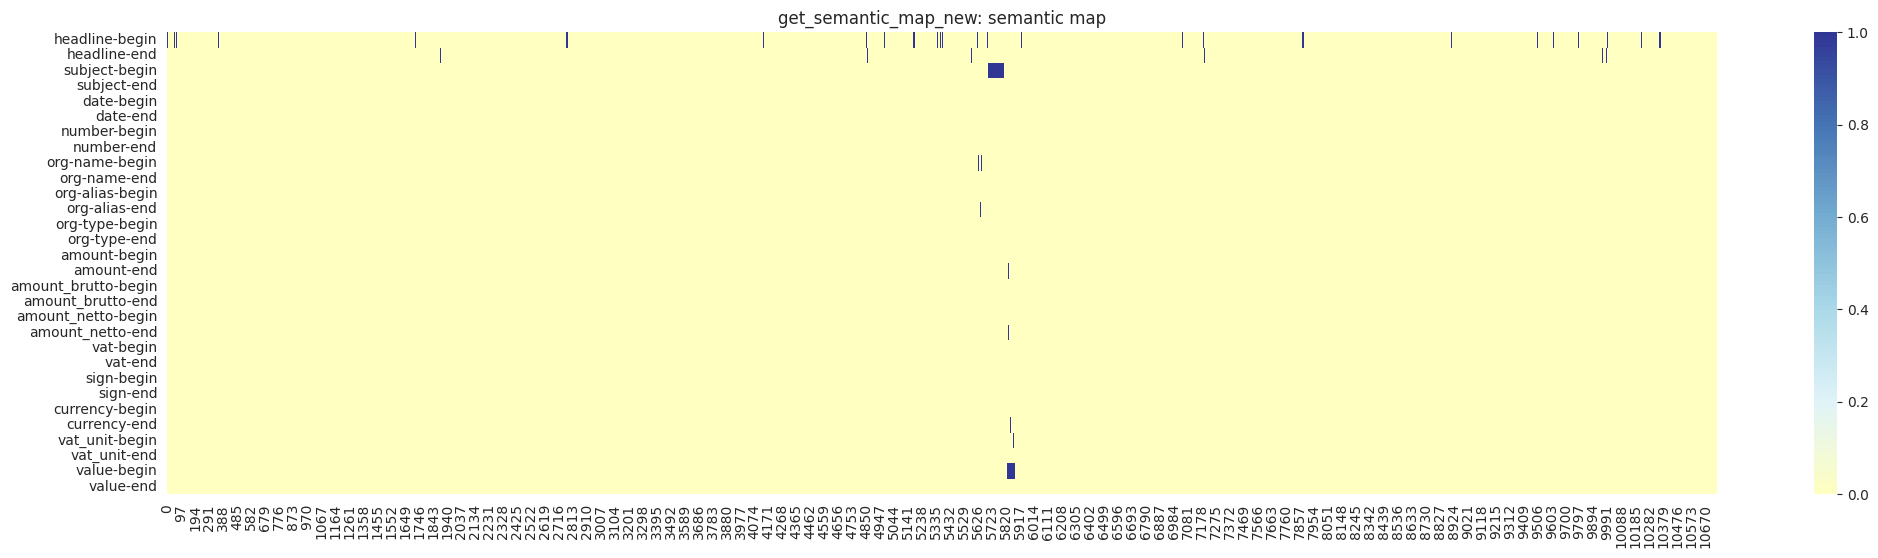

In [14]:
#test one

d = get_doc_by_id(ObjectId('636dfd1473925c8dae26f910'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)


    plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')

### Adding data from old json file to the stats table

In [15]:
# fff
files_dict = {}

if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1   1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd   2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb   2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260   2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5   2.0.5   
...                         ...                               ...     ...   
5ee188952281f29204c522dc   file  520bf70b9df1ee9ee999fe870d936a51  1.11.2   
5efe9252777d4b67a92d5621   file  ed9385088ed6d9c967a9b68a8d10ecc2   2.0.0   
5efe9280777d4b67a92d56ce   file  02a4101c17ceaa4b9d473f6840ac4d7a   2.0.0   
5efe9288777d4b67a92d56d3   file  33f326573547c95e1d381eecd79136a2   2.0.0   
5f016dee777d4b67a92d5840   file  4ea9485a7c529809ed110d0c77f2e16f   2.0.0   

                                         export_date      len  \
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394   5847.0   
5fb376e2d8c9df1ed123726c  2023-01-31 18:32:26.281114   2794.0   
5fb399dc39d5e82e90818474  2023-01-31 18:32:26.380129   3742.0   
5fb3b97d00881c332b567292  2023-01-31 18:35:58.018598   2248.0   
5fb3b97e00881c332b5672bd  2023-01-31 18:32:26.391339   3546.0   
...                                              ...      ...   
5ee188952281f29204c522dc  2023-02-06 11:13:04.589817   7298.0   
5efe9252777d4b67a92d5621  2023-02-06 11:13:12.965704  19504.0   
5efe9280777d4b67a92d56ce  2023-02-06 11:13:14.194385  14025.0   
5efe9288777d4b67a92d56d3  2023-02-06 11:13:14.477587  19219.0   
5f016dee777d4b67a92d5840  2023-02-06 11:13:14.723483     27.0   

                                             analyze_date       value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  25236322.0   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00      2970.0   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00     90000.0   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00         NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  15482412.0   
...                                                   ...         ...   
5ee188952281f29204c522dc 2020-06-12 22:43:06.038000+00:00         NaN   
5efe9252777d4b67a92d5621 2020-07-03 16:50:25.668000+00:00  65300168.0   
5efe9280777d4b67a92d56ce 2020-07-03 21:47:22.279000+00:00         NaN   
5efe9288777d4b67a92d56d3 2020-07-03 21:15:51.170000+00:00         NaN   
5f016dee777d4b67a92d5840 2020-07-05 14:13:31.165000+00:00         NaN   

                          value_log1p  value_span currency  ... org-1-alias  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...         –ì–ü–ù   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB  ...  –ü–æ–∫—É–ø–∞—Ç–µ–ª—å   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB  ...   –ê—Ä–µ–Ω–¥–∞—Ç–æ—Ä   
5fb3b97d00881c332b567292          NaN         NaN      NaN  ...   –ü—Ä–∏–Ω—Ü–∏–ø–∞–ª   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB  ...       –ê–≥–µ–Ω—Ç   
...                               ...         ...      ...  ...         ...   
5ee188952281f29204c522dc          NaN         NaN      NaN  ...         NaN   
5efe9252777d4b67a92d5621    17.994505      7412.0      RUB  ...    –ó–∞–∫–∞–∑—á–∏–∫   
5efe9280777d4b67a92d56ce          NaN         NaN      NaN  ...         NaN   
5efe9288777d4b67a92d56d3          NaN         NaN      NaN  ...    –ó–∞–∫–∞–∑—á–∏–∫   
5f016dee777d4b67a92d5840          NaN         NaN      NaN  ...         NaN   

                                                                 org-2-name  \
5ec2b8da665f7603e03b1255                                                SUN   
5fb376e2d8c9df1ed123726c  –ò—ñ–¥–∞—Ç–µ. —Ç—å—Å–∫–æ-—ñ—ñ–æ. —Ç–∏—ñ —Ä–∞—Ñ–Ω—á–µ—Å–∫–æ–µ –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ ...   
5fb399dc39d5e82e90818474  –§–æ–Ω–¥ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π, –∏–Ω–Ω–æ–≤–∞—Ü–∏–π, –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–π –¢—é–º–µ–Ω...   
5fb3b97d00881c332b567292                       

In [16]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



Empty DataFrame
Columns: [source, checksum, version, export_date, len, analyze_date, value, value_log1p, value_span, currency, org-1-name, org-1-alias, org-2-name, org-2-alias, subject, subject confidence, user_correction_date, valid, documentType, subj_len, headers]
Index: []

[0 rows x 21 columns]

In [17]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
invalid

134: number of invalid records


source                          checksum version  \
62947a20df54d406a99b15b1     db  e0a4a3a2aefe5867844d1821febdcbd1   3.0.0   
62948c5cdf54d406a99b15c6     db  d1a0c7ae08a3c1a32419d1686c001eff   3.0.0   
629f4c5841f3e78db0acc603     db  2b4fc710def608f726016b949c86ec86   3.0.0   
62a99d94326a4191e5f17392     db  434d150b1e1996e94e81bd882d899df9   3.0.0   
62b0742efe720621f7ce44a3     db  67f3089b0b87c8543990a412fb16d370   3.0.0   
...                         ...                               ...     ...   
5ee188952281f29204c522dc   file  520bf70b9df1ee9ee999fe870d936a51  1.11.2   
5efe9252777d4b67a92d5621   file  ed9385088ed6d9c967a9b68a8d10ecc2   2.0.0   
5efe9280777d4b67a92d56ce   file  02a4101c17ceaa4b9d473f6840ac4d7a   2.0.0   
5efe9288777d4b67a92d56d3   file  33f326573547c95e1d381eecd79136a2   2.0.0   
5f016dee777d4b67a92d5840   file  4ea9485a7c529809ed110d0c77f2e16f   2.0.0   

                                         export_date      len  \
62947a20df54d406a99b15b1  2023-01-31 18:20:55.958989    645.0   
62948c5cdf54d406a99b15c6  2023-01-31 18:20:55.965194    249.0   
629f4c5841f3e78db0acc603  2023-01-31 18:20:56.506256    207.0   
62a99d94326a4191e5f17392  2023-01-31 18:20:56.671357    323.0   
62b0742efe720621f7ce44a3  2023-01-31 18:20:57.913462    312.0   
...                                              ...      ...   
5ee188952281f29204c522dc  2023-02-06 11:13:04.589817   7298.0   
5efe9252777d4b67a92d5621  2023-02-06 11:13:12.965704  19504.0   
5efe9280777d4b67a92d56ce  2023-02-06 11:13:14.194385  14025.0   
5efe9288777d4b67a92d56d3  2023-02-06 11:13:14.477587  19219.0   
5f016dee777d4b67a92d5840  2023-02-06 11:13:14.723483     27.0   

                                             analyze_date       value  \
62947a20df54d406a99b15b1 2022-05-30 11:04:02.908000+00:00         NaN   
62948c5cdf54d406a99b15c6 2022-05-30 12:21:20.439000+00:00         NaN   
629f4c5841f3e78db0acc603 2022-06-07 16:04:20.632000+00:00         NaN   
62a99d94326a4191e5f17392 2022-06-15 11:59:11.578000+00:00         NaN   
62b0742efe720621f7ce44a3 2022-06-20 16:22:30.360000+00:00         NaN   
...                                                   ...         ...   
5ee188952281f29204c522dc 2020-06-12 22:43:06.038000+00:00         NaN   
5efe9252777d4b67a92d5621 2020-07-03 16:50:25.668000+00:00  65300168.0   
5efe9280777d4b67a92d56ce 2020-07-03 21:47:22.279000+00:00         NaN   
5efe9288777d4b67a92d56d3 2020-07-03 21:15:51.170000+00:00         NaN   
5f016dee777d4b67a92d5840 2020-07-05 14:13:31.165000+00:00         NaN   

                          value_log1p  value_span currency  ... org-1-alias  \
62947a20df54d406a99b15b1          NaN         NaN      NaN  ...         NaN   
62948c5cdf54d406a99b15c6          NaN         NaN      NaN  ...         NaN   
629f4c5841f3e78db0acc603          NaN         NaN      NaN  ...         NaN   
62a99d94326a4191e5f17392          NaN         NaN      NaN  ...         NaN   
62b0742efe720621f7ce44a3          NaN         NaN      NaN  ...         NaN   
...                               ...         ...      ...  ...         ...   
5ee188952281f29204c522dc          NaN         NaN      NaN  ...         NaN   
5efe9252777d4b67a92d5621    17.994505      7412.0      RUB  ...    –ó–∞–∫–∞–∑—á–∏–∫   
5efe9280777d4b67a92d56ce          NaN         NaN      NaN  ...         NaN   
5efe9288777d4b67a92d56d3          NaN         NaN      NaN  ...    –ó–∞–∫–∞–∑—á–∏–∫   
5f016dee777d4b67a92d5840          NaN         NaN      NaN  ...         NaN   

                                       org-2-name  org-2-alias subject  \
62947a20df54d406a99b15b1                      NaN          NaN   Other   
62948c5cdf54d406a99b15c6                      NaN          NaN   Other   
629f4c5841f3e78db0acc603                      NaN          NaN   Other   
62a99d94326a4191e5f17392                      NaN          NaN   Other   
62b0742efe720621f7ce44a3                      NaN          NaN   Other   
...                              

In [18]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [19]:


# if True:
lastdate = lastdate + relativedelta(days=-5)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-01-30 11:02:49.897000+0000', tz='UTC')

In [20]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### –í—Å–µ–≥–æ –Ω–æ–≤—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –ø–æ—Å–ª–µ {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### –í—Å–µ–≥–æ –Ω–æ–≤—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –ø–æ—Å–ª–µ 2023-01-30 11:02:49.897000+00:00 : 182

[{'_id': ObjectId('5ec2b8d8665f7603e03b122b'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 2, 14, 26, 8, 111000)}},
 {'_id': ObjectId('5fb278c1d8c9df1ed1236d47'),
  'user': {'updateDate': datetime.datetime(2023, 2, 2, 14, 19, 22, 231000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}},
 {'_id': ObjectId('5fb399dd39d5e82e90818477'),
  'user': {'updateDate': datetime.datetime(2023, 2, 4, 8, 18, 39, 335000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}},
 {'_id': ObjectId('5fbbe467a2b4551c06107b06'),
  'user': {'updateDate': datetime.datetime(2023, 2, 3, 13, 14, 25, 102000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [21]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

182


In [22]:
new_docs_ids

[ObjectId('5ec2b8d8665f7603e03b122b'),
 ObjectId('5fb278c1d8c9df1ed1236d47'),
 ObjectId('5fb399dd39d5e82e90818477'),
 ObjectId('5fbbe467a2b4551c06107b06'),
 ObjectId('5fbf668c5d05d73d0295fa46'),
 ObjectId('5fbf75af5d05d73d0295fa96'),
 ObjectId('5fbf75ae5d05d73d0295fa82'),
 ObjectId('5fbf75ad5d05d73d0295fa6b'),
 ObjectId('5fbf75af5d05d73d0295faa0'),
 ObjectId('5fc5eb6b1d0a1603c7a0c8b2'),
 ObjectId('5fbbe46aa2b4551c06107ba5'),
 ObjectId('5fca2aab9083b679224c75e7'),
 ObjectId('5fca2aac9083b679224c75f7'),
 ObjectId('5fca2aab9083b679224c75ea'),
 ObjectId('5fca2aac9083b679224c7600'),
 ObjectId('5fca2aac9083b679224c75f6'),
 ObjectId('5fca2ab09083b679224c7639'),
 ObjectId('5fca2ab39083b679224c7655'),
 ObjectId('5fca2ab49083b679224c7659'),
 ObjectId('5fca2ab09083b679224c762f'),
 ObjectId('5fc6452a1d0a1603c7a0c9e8'),
 ObjectId('5fdb2141542ce403c92b4576'),
 ObjectId('5fc63d611d0a1603c7a0c96b'),
 ObjectId('5fc7a038c54bc33809e2621d'),
 ObjectId('5fc7a036c54bc33809e261f7'),
 ObjectId('5fc7a037c54bc3

In [23]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [24]:
def add_to_stats_list(docs_ids):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
            add_stats_record(jd, stats)
        except Exception as e:
            print(oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
add_to_stats_list(docs_ids)        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 182
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
100 of 182
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63dccb422c90db0b7a62aab1     db  f31c50b18a70c7d3c76739d3f3a75883  23.01.23   
63dccb3a2c90db0b7a62aa13     db  eecf932911e62f5c54ca4cb17d52e000  23.01.23   
63dccb3c2c90db0b7a62aa21     db  eecf932911e62f5c54ca4cb17d52e000  23.01.23   
62862adb4d1bfe5e5b297dee     db  c81664bbc202b2a143fe57dfcb950348  23.01.23   
6392ff311002115a6029f3b0     db  33e3b53056dfc2b36756b96634a31ee3  23.01.23   

                                         export_date      len  \
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394   5847.0   
5fb376e2d8c9df1ed123726c  2023-01-31 18:32:26.281114   2794.0   
5fb399dc39d5e82e90818474  2023-01-31 18:32:26.380129   3742.0   
5fb3b97d00881c332b567292  2023-01-31 18:35:58.018598   2248.0   
5fb3b97e00881c332b5672bd  2023-01-31 18:32:26.391339   3546.0   
...                                              ...      ...   
63dccb422c90db0b7a62aab1  2023-02-06 11:13:22.924804    289.0   
63dccb3a2c90db0b7a62aa13  2023-02-06 11:13:22.929096    661.0   
63dccb3c2c90db0b7a62aa21  2023-02-06 11:13:22.933407    661.0   
62862adb4d1bfe5e5b297dee  2023-02-06 11:13:23.503476  25014.0   
6392ff311002115a6029f3b0  2023-02-06 11:13:23.515922   2676.0   

                                             analyze_date         value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00  2.970000e+03   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00  9.000000e+04   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00           NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  1.548241e+07   
...                                                   ...           ...   
63dccb422c90db0b7a62aab1 2023-02-03 12:48:21.573000+00:00           NaN   
63dccb3a2c90db0b7a62aa13 2023-02-03 18:02:04.250000+00:00  1.000000e+08   
63dccb3c2c90db0b7a62aa21 2023-02-03 18:02:06.033000+00:00  1.000000e+08   
62862adb4d1bfe5e5b297dee 2023-02-04 11:20:30.480000+00:00  3.050000e+09   
6392ff311002115a6029f3b0 2023-02-04 11:21:07.266000+00:00           NaN   

                          value_log1p  value_span currency  ... org-1-alias  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...         –ì–ü–ù   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB  ...  –ü–æ–∫—É–ø–∞—Ç–µ–ª—å   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB  ...   –ê—Ä–µ–Ω–¥–∞—Ç–æ—Ä   
5fb3b97d00881c332b567292          NaN         NaN      NaN  ...   –ü—Ä–∏–Ω—Ü–∏–ø–∞–ª   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB  ...       –ê–≥–µ–Ω—Ç   
...                               ...         ...      ...  ...         ...   
63dccb422c90db0b7a62aab1          NaN         NaN      NaN  ...  –ó–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb3a2c90db0b7a62aa13    18.420681       290.0     None  ...      –ì–∞—Ä–∞–Ω—Ç   
63dccb3c2c90db0b7a62aa21    18.420681       290.0     None  ...      –ì–∞—Ä–∞–Ω—Ç   
62862adb4d1bfe5e5b297dee    21.838407     14195.0      RUB  ...    –ó–∞–∫–∞–∑—á–∏–∫   
6392ff311002115a6029f3b0          NaN         NaN      RUB  ...    –ü—Ä–æ–¥–∞–≤–µ—Ü   

                                                                 org-2-name  \
5ec2b8da665f7603e03b1255                                                SUN   
5fb376e2d8c9df1ed123726c  –ò—ñ–¥–∞—Ç–µ. —Ç—å—Å–∫–æ-—ñ—ñ–æ. —Ç–∏—ñ —Ä–∞—Ñ–Ω—á–µ—Å–∫–æ–µ –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ ...   
5fb399dc39d5e82e90818474  –§–æ–Ω–¥ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π, –∏–Ω–Ω–æ–≤–∞—Ü–∏–π, –∏–Ω–≤–µ—Å—Ç–∏—

In [25]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s[s['headers'].isna()].index)
print(len(_ids))
add_to_stats_list(_ids)     
print(f'saving to {export_fn}; {len(stats)} records')
stats.to_csv(export_fn, index=True)

13
637397e2a8eb8dc64b37543b
'NoneType' object is not iterable
0 of 13
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
637397e2a8eb8dc64b37543c
'NoneType' object is not iterable
637397e2a8eb8dc64b37543d
'NoneType' object is not iterable
637397e2a8eb8dc64b37543f
'NoneType' object is not iterable
637397e2a8eb8dc64b375440
'NoneType' object is not iterable
637397e2a8eb8dc64b375441
'NoneType' object is not iterable
637397e2a8eb8dc64b37543a
'NoneType' object is not iterable
637397e2a8eb8dc64b37543e
'NoneType' object is not iterable
637e11d66a07f3e980b2bfbf
'NoneType' object is not iterable
637e11d76a07f3e980b2bfc0
'NoneType' object is not iterable
637f2826fe09513dc6b2bfbf
'NoneType' object is not iterable
637f2826fe09513dc6b2bfc0
'NoneType' object is not iterable
637f725ec15a83c52bb2bfc1
'NoneType' object is not iterable
saving to /root/artem/work/contract_trainset_meta.temp.csv; 6757 records


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [26]:
stats = stats[stats.valid!=False]
len(stats)

6539

In [27]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63dccb422c90db0b7a62aaa0     db  0fd8c821da37f3fa8e44c53767fb7842  23.01.23   
63dccb3f2c90db0b7a62aa4f     db  63eb26415678c8e225543264d981d460  23.01.23   
63dccb3f2c90db0b7a62aa5d     db  5b8260ef4f47dfb261a3ee74193fc576  23.01.23   
63dccb402c90db0b7a62aa77     db  94bb8a85bfb0d2168a144ec23aa7e99b  23.01.23   
63dccb412c90db0b7a62aa98     db  5b8260ef4f47dfb261a3ee74193fc576  23.01.23   

                                         export_date     len  \
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394  5847.0   
5fb376e2d8c9df1ed123726c  2023-01-31 18:32:26.281114  2794.0   
5fb399dc39d5e82e90818474  2023-01-31 18:32:26.380129  3742.0   
5fb3b97d00881c332b567292  2023-01-31 18:35:58.018598  2248.0   
5fb3b97e00881c332b5672bd  2023-01-31 18:32:26.391339  3546.0   
...                                              ...     ...   
63dccb422c90db0b7a62aaa0  2023-02-06 11:13:22.841404  1398.0   
63dccb3f2c90db0b7a62aa4f  2023-02-06 11:13:22.889946   422.0   
63dccb3f2c90db0b7a62aa5d  2023-02-06 11:13:22.895283   432.0   
63dccb402c90db0b7a62aa77  2023-02-06 11:13:22.904573   360.0   
63dccb412c90db0b7a62aa98  2023-02-06 11:13:22.913612   432.0   

                                             analyze_date       value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  25236322.0   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00      2970.0   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00     90000.0   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00         NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  15482412.0   
...                                                   ...         ...   
63dccb422c90db0b7a62aaa0 2023-02-03 12:45:55.389000+00:00         NaN   
63dccb3f2c90db0b7a62aa4f 2023-02-03 12:46:57.294000+00:00         NaN   
63dccb3f2c90db0b7a62aa5d 2023-02-03 12:47:14.155000+00:00         NaN   
63dccb402c90db0b7a62aa77 2023-02-03 12:47:53.920000+00:00         NaN   
63dccb412c90db0b7a62aa98 2023-02-03 12:48:01.599000+00:00         NaN   

                          value_log1p  value_span currency  ... org-1-alias  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...         –≥–ø–Ω   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB  ...  –ø–æ–∫—É–ø–∞—Ç–µ–ª—å   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB  ...   –∞—Ä–µ–Ω–¥–∞—Ç–æ—Ä   
5fb3b97d00881c332b567292          NaN         NaN      NaN  ...   –ø—Ä–∏–Ω—Ü–∏–ø–∞–ª   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB  ...       –∞–≥–µ–Ω—Ç   
...                               ...         ...      ...  ...         ...   
63dccb422c90db0b7a62aaa0          NaN         NaN   —Ä—É–±–ª–µ–π  ...  –∑–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb3f2c90db0b7a62aa4f          NaN         NaN      NaN  ...  –∑–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb3f2c90db0b7a62aa5d          NaN         NaN      NaN  ...  –∑–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb402c90db0b7a62aa77          NaN         NaN      NaN  ...  –∑–∞–π–º–æ–¥–∞–≤–µ—Ü   
63dccb412c90db0b7a62aa98          NaN         NaN      NaN  ...  –∑–∞–π–º–æ–¥–∞–≤–µ—Ü   

                                                                 org-2-name  \
5ec2b8da665f7603e03b1255                                                sun   
5fb376e2d8c9df1ed123726c  –∏—ñ–¥–∞—Ç–µ. —Ç—å—Å–∫–æ-—ñ—ñ–æ. —Ç–∏—ñ —Ä–∞—Ñ–Ω—á–µ—Å–∫–æ–µ –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ ...   
5fb399dc39d5e82e90818474  —Ñ–æ–Ω–¥ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π, –∏–Ω–Ω–æ–≤–∞—Ü–∏–π, –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–π —Ç—é–º–µ–Ω..

In [28]:
stats2['subject'].value_counts()

Other                                2572
Service                              2091
Deal                                  497
Renting                               199
Loans                                 193
GeneralContract                       181
AgencyContract                         94
DealIntellectualProperty               88
Charity                                82
Insurance                              60
RealEstate                             37
ParticipationInOtherOrganizations      24
RealEstateTransactions                 21
PledgeEncumbrance                      20
BankGuarantees                         14
SecuritiesTransactions                 11
EmployeeContracts                       2
BigDeal                                 2
AssetTransactions                       1
DealGeneralBusiness                     1
Name: subject, dtype: int64

In [29]:
stats2['org-1-alias'].value_counts()

–∑–∞–∫–∞–∑—á–∏–∫           1500
–∏—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å         616
–ø–æ–∫—É–ø–∞—Ç–µ–ª—å          351
–ø–æ—Å—Ç–∞–≤—â–∏–∫           155
–ø—Ä–æ–¥–∞–≤–µ—Ü            137
                   ... 
–±–ª–∞–≥–æ–ø–æ–ª—É—á–∞—Ç–µ–ª—å       1
—É–Ω–∏—Å–∏—Ç                1
—Ä–µ–≥–∏—Å—Ç—Ä–∞—Ç–æ—Ä           1
—Ç–∑–∫                   1
–ø—Ä–æ–º–∫–∞—Ç–∞–ª–∏–∑           1
Name: org-1-alias, Length: 95, dtype: int64

In [30]:
stats2['org-2-alias'].value_counts()

–∏—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å         1218
–∑–∞–∫–∞–∑—á–∏–∫             655
–ø–æ—Å—Ç–∞–≤—â–∏–∫            295
–ø–æ–∫—É–ø–∞—Ç–µ–ª—å           266
–ø–æ–¥—Ä—è–¥—á–∏–∫            252
                    ... 
–≤–µ—Å–Ω–∞                  1
–±–ª–∞–≥–æ—Ç–≤–æ—Ä–∏—Ç–µ–ª—å         1
–ø—Ä–∞–≤–∏—Ç–µ–ª—å—Å—Ç–≤–æ          1
–±—Ä–æ–∫–µ—Ä                 1
–Ω–∞–ª–æ–≥–æ–ø–ª–∞—Ç–µ–ª—å—â–∏–∫       1
Name: org-2-alias, Length: 98, dtype: int64

In [31]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

6539


source                          checksum     version  \
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d       3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1       1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e       2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a      1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3   23.1.27.1   
63908ca4a1bded13e629f2eb     db  3bc04887446d02692e886db2545bba61     22.12.7   
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db     22.12.7   
633fd0a69d08c565cfa1232a     db  61cfee32867b371843d1e95a194ea2a6       3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6       3.0.0   
6246a3fa25a983726c7694af     db  61cfee32867b371843d1e95a194ea2a6       3.0.0   
5ec2b8da665f7603e03b127e     db  71d364cbfd07a7a940a8d7de159e1229       1.6.5   
5e587dce99b345c81a70340d   file  c7638957131b716a710dcb357e4dc198      1.12.0   
5fbf75af5d05d73d0295fa99     db  9f0be084f7a24f3b408dd5baf95195c3       2.0.5   
635fa420bf4cb23cbb39282f     db  cae67be3fb8b4cf81a623922a8837c36    23.01.23   
636dfd1473925c8dae26f910     db  04a3e9defa47d894d07550ae99cf95d1       3.0.0   
636d031e73925c8dae26f90e     db  4abd6c70b4e58225b824357d6bf780a1       3.0.0   
5fb399dd39d5e82e9081847d     db  5538125725572fda3b474800b12766f5       2.0.5   
5fbbe46ca2b4551c06107c21     db  c116f846e9ee6ececa07e15ae213552e       2.0.5   
5fb6750a33c72547b755010d     db  4c6124d0661a45e03c7dec4eba94bb0a       2.0.5   
5fbbbd1ca2b4551c06107a5f     db  4c6124d0661a45e03c7dec4eba94bb0a       2.0.5   
638085746a07f3e980b2c25b     db  cd9155db2d14d7c0e941c8b68fd1636c     22.12.7   
634515c4172785f510f15e05     db  1e0b396c361ad164ee654ffb57a3b508       3.0.0   
60002ae0b08473039387bcf4     db  5b4cb8bd63a9fdc04e41a8bed71992ee      2.3.14   
5fe34f64b770574a005553f2     db  79309d55935a90a2e5a66e50da1fc5dc      2.3.13   
5e58df7823869ee43538823d   file  deb48609e432ddfd62bdafa027d52052      1.11.2   
5feb3e50bd24992aa31040df     db  b2fe1c5c9532863410f5827d872fe753      2.3.14   
5deba9034ddc27bcf92dd383   file  7e9e0a5f729f876a5b3055de5076db9d      1.10.0   
5ec2b8d9665f7603e03b1238     db  7e9e0a5f729f876a5b3055de5076db9d       1.6.5   
5fe34f63b770574a005553db     db  b42ed28b9a72f51612db24cbd7b7a4f0      2.3.13   
63c92b5cfb21317f1d5e0f7c     db  57cce4467ee80797fbe4b8e5d69c8742    23.01.04   
60002adfb08473039387bcc5     db  57cce4467ee80797fbe4b8e5d69c8742     22.12.7   
5e58df7823869ee435388239   file  bdccb8e9a4bccb217b504a67f12661f1      1.11.2   
5e5de70c01c6c73c19eebd38   file  bdccb8e9a4bccb217b504a67f12661f1      1.12.0   
63908ca3a1bded13e629f2de     db  03455452b993eb289683fa17c0b997fd     22.12.6   
635fa420bf4cb23cbb39282d     db  af0f27d99859108243db6d7fa3e3ae9c    23.01.23   
62dfbce15d5a202ba67b842d     db  61cfee32867b371843d1e95a194ea2a6       3.0.0   
5edbc65dda3678279fbcae6a   file  f06a02c4afcf2f8280c04a2cb31082e6       2.0.2   
639083617fc8981f6e29f2e9     db  daa1fec657ec24b7314d0ef2d3a9f411     22.12.7   
639844794b01c8adaa5a4ee5     db  d7ab4b582b4ecac8577858ca0622d4ba     22.12.7   
63a43aafbeaa9eeec65ecb22     db  1e8a5b61dccd4ded711f96180ec11fe9  22.12.15.1   

                                         export_date      len  \
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517   6747.0   
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394   5847.0   
5edbc62eda3678279fbcadf3  2023-02-06 11:13:01.260685   1373.0   
5ded4e284ddc27bcf92dd6ce  2023-02-06 11:12:57.718593    460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376   8535.0   
63908ca4a1bded13e629f2eb  2023-01-31 18:38:08.500901  13410.0   
6391b4771864c6df4d29f332  2023-02-06 11:13:20.612545   1990.0   
633fd0a69d08c565cfa1232a  2023-02-01 17:26:54.225685   5556.0   
6285f9c04d1bfe5e5b297ddd  2023-02-01 17:26:53.153480   5556.0   
6246a3fa25a983726c7694af  2023-01-31 18:32:42.511519 

In [32]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [33]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

source                          checksum   version  \
5fc7a047c54bc33809e26372     db  82137d4b0ded9b81b1d12f4d9e98c383     2.0.5   
5fca2acd9083b679224c77da     db  6b64d52e5ecb4941696164ed4950e735     2.0.5   
5fb3b9a800881c332b567433     db  287d93101b752b5f041d476d7196864e     2.0.5   
5f09a55a138e9184feef1f3d   file  1a9db8f1670e2e976b777841a0cd3412     2.0.4   
5f09c1c7138e9184feef1f69   file  1a9db8f1670e2e976b777841a0cd3412     2.0.1   
...                         ...                               ...       ...   
638f0a7fb1363747e929f2ec     db  109407c8fd295cd3e3bf6c51ae8c8c4f   22.12.6   
638f0a7fb1363747e929f2f0     db  0cbc9c41015ca9671bab95c12d5760a4   22.12.6   
638f0a7fb1363747e929f2ef     db  16bbfb78a184b3f37e6c9866aa4c94d9   22.12.6   
63c506bde2456d59975e1112     db  0cbc9c41015ca9671bab95c12d5760a4  23.01.04   
63c506bde2456d59975e110e     db  109407c8fd295cd3e3bf6c51ae8c8c4f  23.01.04   

                                         export_date      len  \
5fc7a047c54bc33809e26372  2023-01-31 18:21:21.813526  49340.0   
5fca2acd9083b679224c77da  2023-01-31 18:21:28.019257  49040.0   
5fb3b9a800881c332b567433  2023-01-31 18:21:09.911469  44180.0   
5f09a55a138e9184feef1f3d  2023-02-06 11:13:16.090214  39860.0   
5f09c1c7138e9184feef1f69  2023-02-06 11:13:17.487559  39860.0   
...                                              ...      ...   
638f0a7fb1363747e929f2ec  2023-01-31 18:38:07.384039     10.0   
638f0a7fb1363747e929f2f0  2023-01-31 18:38:07.387106     10.0   
638f0a7fb1363747e929f2ef  2023-01-31 18:38:07.386171     10.0   
63c506bde2456d59975e1112  2023-01-31 18:38:08.881351     10.0   
63c506bde2456d59975e110e  2023-01-31 18:38:08.879568     10.0   

                                             analyze_date       value  \
5fc7a047c54bc33809e26372 2020-12-03 08:07:48.699000+00:00  90619807.0   
5fca2acd9083b679224c77da 2020-12-10 10:40:36.652000+00:00  90619807.0   
5fb3b9a800881c332b567433 2020-11-17 11:54:59.086000+00:00         NaN   
5f09a55a138e9184feef1f3d 2020-10-04 10:50:52.531000+00:00         NaN   
5f09c1c7138e9184feef1f69 2020-07-11 21:43:23.938000+00:00         NaN   
...                                                   ...         ...   
638f0a7fb1363747e929f2ec 2022-12-06 12:27:52.306000+00:00         NaN   
638f0a7fb1363747e929f2f0 2022-12-06 12:27:53.027000+00:00         NaN   
638f0a7fb1363747e929f2ef 2022-12-06 12:27:52.856000+00:00         NaN   
63c506bde2456d59975e1112 2023-01-16 11:36:53.287000+00:00         NaN   
63c506bde2456d59975e110e 2023-01-16 11:36:52.238000+00:00         NaN   

                          value_log1p  value_span currency  ...  \
5fc7a047c54bc33809e26372    18.322183      4503.0      RUB  ...   
5fca2acd9083b679224c77da    18.322183      4207.0      RUB  ...   
5fb3b9a800881c332b567433          NaN         NaN      NaN  ...   
5f09a55a138e9184feef1f3d          NaN         NaN      NaN  ...   
5f09c1c7138e9184feef1f69          NaN         NaN      NaN  ...   
...                               ...         ...      ...  ...   
638f0a7fb1363747e929f2ec          NaN         NaN      NaN  ...   
638f0a7fb1363747e929f2f0          NaN         NaN      NaN  ...   
638f0a7fb1363747e929f2ef          NaN         NaN      NaN  ...   
63c506bde2456d59975e1112          NaN         NaN      NaN  ...   
63c506bde2456d59975e110e          NaN         NaN      NaN  ...   

                                  subject subject confidence  \
5fc7a047c54bc33809e26372          Service           0.896091   
5fca2acd9083b679224c77da  GeneralContract           1.000000   
5fb3b9a800881c332b567433              NaN                NaN   
5f09a55a138e9184feef1f3d          Service           1.000000   
5f09c1c7138e9184feef1f69          Service           0.998361   
...                                   ...                ...   
638f0a7fb1363747e929f2ec            Other           0.984498   
638f0a7fb1363747e929f2f0            Other           0.984397   
638f0a7fb1363747e929f2ef            O

In [34]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

6539


source                          checksum   version  \
5fc63d611d0a1603c7a0c97d     db  08a1ee1556c3a53d857945a3f718e245     2.0.5   
5fb6750a33c72547b7550105     db  ea90f51aca035518002bd3606c56defe     2.0.5   
5fbbbd19a2b4551c061079cc     db  ea90f51aca035518002bd3606c56defe     2.0.5   
5fb3d7a478df3635f5441dd2     db  7d95a7e6eeb468ba57094eb3c6ec1cc7     2.0.5   
5fe4821eb770574a00555722     db  7d95a7e6eeb468ba57094eb3c6ec1cc7    2.3.13   
...                         ...                               ...       ...   
63c506e2e2456d59975e1500     db  63f6600e241fc8eb309690a49e0bb64e  23.01.04   
63ce4b03e83d1ee490f4002f     db  95d0e4e41638a417c5bf8e1f3c93e095  23.01.23   
5fdb213d542ce403c92b4518     db  31604ed02e098d52c45b37a72f97f91d     2.0.5   
5eea27b4c28b75807f3daf5d   file  a3bcc95df8316b8868735383b27447a5     2.0.1   
5fb278c2d8c9df1ed1236d63     db  4a6f4a33fb5fdf7040023fb18293cfc2     2.0.5   

                                         export_date     len  \
5fc63d611d0a1603c7a0c97d  2023-01-31 18:36:05.219186   710.0   
5fb6750a33c72547b7550105  2023-01-31 18:32:31.776455  3050.0   
5fbbbd19a2b4551c061079cc  2023-01-31 18:32:32.564032  3050.0   
5fb3d7a478df3635f5441dd2  2023-01-31 18:21:11.488553  2800.0   
5fe4821eb770574a00555722  2023-01-31 18:36:06.222269  2800.0   
...                                              ...     ...   
63c506e2e2456d59975e1500  2023-01-31 21:42:47.066704  4600.0   
63ce4b03e83d1ee490f4002f  2023-01-31 21:43:34.968513  6980.0   
5fdb213d542ce403c92b4518  2023-01-31 18:32:37.962601  1260.0   
5eea27b4c28b75807f3daf5d  2023-02-06 11:13:07.292805  6370.0   
5fb278c2d8c9df1ed1236d63  2023-01-31 18:32:28.705299  2960.0   

                                             analyze_date         value  \
5fc63d611d0a1603c7a0c97d 2020-12-18 10:43:04.513000+00:00           NaN   
5fb6750a33c72547b7550105 2020-11-19 14:27:31.189000+00:00  4.930520e+05   
5fbbbd19a2b4551c061079cc 2020-11-23 14:13:32.616000+00:00  4.930520e+05   
5fb3d7a478df3635f5441dd2 2020-11-17 16:05:35.675000+00:00           NaN   
5fe4821eb770574a00555722 2020-12-24 17:40:02.031000+00:00           NaN   
...                                                   ...           ...   
63c506e2e2456d59975e1500 2023-01-16 14:26:48.614000+00:00  5.000000e+02   
63ce4b03e83d1ee490f4002f 2023-01-26 05:00:47.109000+00:00           NaN   
5fdb213d542ce403c92b4518 2020-12-17 16:29:42.386000+00:00  3.168000e+04   
5eea27b4c28b75807f3daf5d 2020-07-11 15:47:09.013000+00:00  2.836434e+07   
5fb278c2d8c9df1ed1236d63 2020-11-16 13:27:52.735000+00:00  2.463528e+09   

                          value_log1p  value_span currency  ...  \
5fc63d611d0a1603c7a0c97d          NaN         NaN      NaN  ...   
5fb6750a33c72547b7550105    13.108372      2005.0      RUB  ...   
5fbbbd19a2b4551c061079cc    13.108372      2005.0      RUB  ...   
5fb3d7a478df3635f5441dd2          NaN         NaN      NaN  ...   
5fe4821eb770574a00555722          NaN         NaN      NaN  ...   
...                               ...         ...      ...  ...   
63c506e2e2456d59975e1500     6.216606       243.0      RUB  ...   
63ce4b03e83d1ee490f4002f          NaN         NaN      NaN  ...   
5fdb213d542ce403c92b4518    10.363472       543.0      RUB  ...   
5eea27b4c28b75807f3daf5d    17.160643      2485.0      RUB  ...   
5fb278c2d8c9df1ed1236d63    21.624860       775.0      RUB  ...   

                         subject confidence             user_correction_date  \
5fc63d611d0a1603c7a0c97d           1.000000 2020-12-18 07:42:51.215000+00:00   
5fb6750a33c72547b7550105           0.997197                              NaT   
5fbbbd19a2b4551c061079cc           0.997197                              NaT   
5fb3d7a478df3635f5441dd2           0.998400                              NaT   
5fe4821eb770574a00555722           1.000000 2021-07-22 14:43:55.954000+00:00   
...                                     ...                              ...   
63c506e2e2456d59975e1500           0.9955

In [35]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

6539

### Drop duplicates

In [36]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

3119


## Remove rare subjects and very long docs

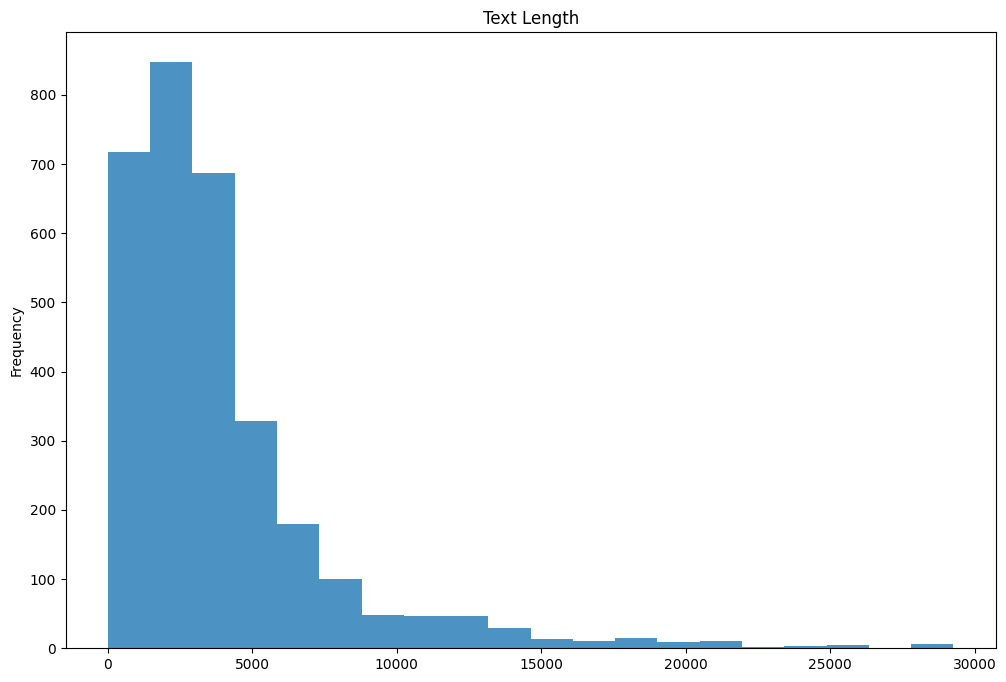

In [37]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.3545353268011222


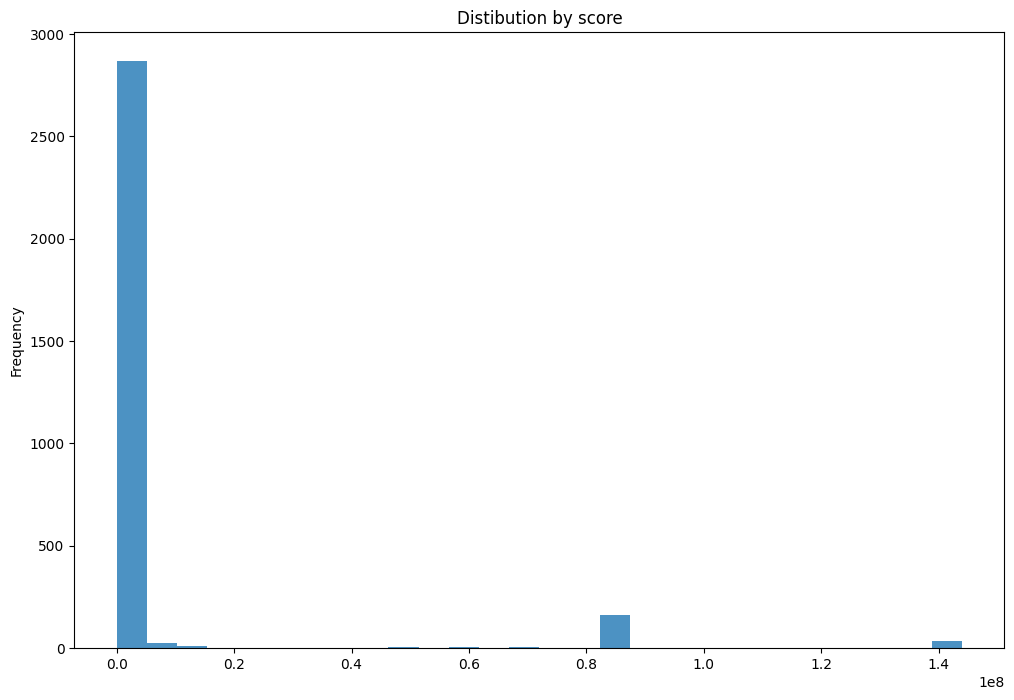

In [38]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [39]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5e58df7823869ee43538823d file GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5e5de70d01c6c73c19eebd4a file GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0
excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding 6246a2d525a983726c76949d db Other 35560.0
excluding 5fb3b9a800881c332b567433 db nan 44180.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5fb6750c33c72547b7550147 db BigDeal
excluding 638085866a07f3e980b2c441 db DealGeneralBusiness
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 610d2b0d7dfce422c4272d39 db EmployeeContracts


Service                              1565
Other                                 429
Deal                                  364
Renting                               143
GeneralContract                       129
Loans                                 106
AgencyContract                         77
DealIntellectualProperty               65
Charity                                52
Insurance                              45
RealEstate                             32
RealEstateTransactions                 16
BankGuarantees                         13
PledgeEncumbrance                      12
ParticipationInOtherOrganizations      11
SecuritiesTransactions                  8
Name: subject, dtype: int64


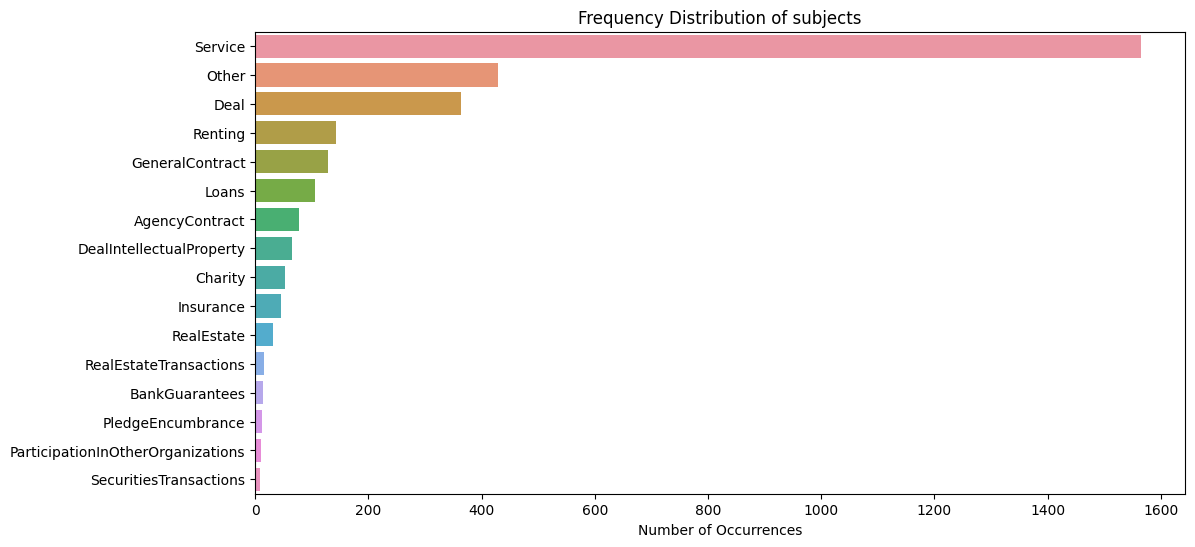

In [40]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [41]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - –í—Å–µ–≥–æ –Ω–æ–≤—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –≤ –æ–±—É—á–∞—é—â–µ–º –Ω–∞–±–æ—Ä–µ –Ω–∞ {lastdate}"
display(Markdown(_s))


dups_s

### 3103 - –í—Å–µ–≥–æ –Ω–æ–≤—ã—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –≤ –æ–±—É—á–∞—é—â–µ–º –Ω–∞–±–æ—Ä–µ –Ω–∞ 2023-01-30 11:02:49.897000+00:00

source                          checksum    version  \
_id                                                                            
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d      3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
...                         ...                               ...        ...   
5fb3b97e00881c332b5672a7     db  cb42faac316b74abe50fd9a1ae5f4149      2.4.4   
6285f51af098f73e14297e43     db  1383512495cf9d32e91a34145a27cf0f      3.0.0   
5fb376e4d8c9df1ed12372a7     db  4fb950c36151bf29c74eea97d9466335      2.5.3   
6285f519f098f73e14297e26     db  6c1dd815d180807ab3a6e0ae6fc1c01f      3.0.0   
5fb3d4a178df3635f5441c7f     db  575a6d281d9ec6b91656173148de50a0      2.4.4   

                                         export_date     len  \
_id                                                            
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517  6740.0   
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394  5840.0   
5edbc62eda3678279fbcadf3  2023-02-06 11:13:01.260685  1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-06 11:12:57.718593   460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376  8530.0   
...                                              ...     ...   
5fb3b97e00881c332b5672a7  2023-01-31 18:37:44.955702   430.0   
6285f51af098f73e14297e43  2023-01-31 18:38:00.159711   190.0   
5fb376e4d8c9df1ed12372a7  2023-01-31 18:37:59.202858   440.0   
6285f519f098f73e14297e26  2023-01-31 18:38:00.153008    90.0   
5fb3d4a178df3635f5441c7f  2023-01-31 18:37:44.019375   210.0   

                                             analyze_date         value  \
_id                                                                       
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
...                                                   ...           ...   
5fb3b97e00881c332b5672a7 2021-07-30 15:12:59.254000+00:00           NaN   
6285f51af098f73e14297e43 2022-05-19 10:45:22.737000+00:00           NaN   
5fb376e4d8c9df1ed12372a7 2021-10-28 15:44:16.851000+00:00           NaN   
6285f519f098f73e14297e26 2022-05-19 10:45:15.048000+00:00           NaN   
5fb3d4a178df3635f5441c7f 2021-07-23 10:57:33.611000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...   
...                               ...         ...      ...  ...   
5fb3b97e00881c332b5672a7          NaN         NaN      NaN  ...   
6285f51af098f73e14297e43          NaN         NaN      NaN  ...   
5fb376e4d8c9df1ed12372a7          NaN         NaN      NaN  ...   
6285f519f098f73e14297e26          NaN         NaN      NaN  ...   
5fb3d4a178df3635f5441c7f          NaN         NaN      NaN  ...   

                                     user_correction_date valid documentType  \
_id                                                                            
6340244c9d08c565cfa12341 2022-10-07 13:43:21.470000+00:00  True    AGREEMENT   
5ec2b8da665f7603e03b1255 2023-01-27 10:27:22.086000+00:00  True

In [42]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [43]:
dups_s[dups_s['unseen']]

source                          checksum   version  \
_id                                                                           
5ec2b8d8665f7603e03b121a     db  74a7be7f14b129ce379aaa0920978a71     1.6.5   
63c506dce2456d59975e145c     db  88a0bf0e851b84960702680c7972f090  23.01.04   
63c506ace2456d59975e0f9f     db  2ff69a29f2a6f16826a6e68dc6cc1d22  23.01.04   
5efe924d777d4b67a92d55b0   file  c056d218b8ae1d56747afd23ac3cf10f     2.0.0   
63c506c8e2456d59975e125c     db  8b9cc038759514b95b5c84b242ca539f  23.01.04   
...                         ...                               ...       ...   
5fb3b97e00881c332b5672a7     db  cb42faac316b74abe50fd9a1ae5f4149     2.4.4   
6285f51af098f73e14297e43     db  1383512495cf9d32e91a34145a27cf0f     3.0.0   
5fb376e4d8c9df1ed12372a7     db  4fb950c36151bf29c74eea97d9466335     2.5.3   
6285f519f098f73e14297e26     db  6c1dd815d180807ab3a6e0ae6fc1c01f     3.0.0   
5fb3d4a178df3635f5441c7f     db  575a6d281d9ec6b91656173148de50a0     2.4.4   

                                         export_date      len  \
_id                                                             
5ec2b8d8665f7603e03b121a  2023-01-31 18:32:27.217863    550.0   
63c506dce2456d59975e145c  2023-01-31 21:42:43.455407   3630.0   
63c506ace2456d59975e0f9f  2023-01-31 21:42:49.474166    430.0   
5efe924d777d4b67a92d55b0  2023-02-06 11:13:09.792844  17580.0   
63c506c8e2456d59975e125c  2023-01-31 21:42:35.639579   1740.0   
...                                              ...      ...   
5fb3b97e00881c332b5672a7  2023-01-31 18:37:44.955702    430.0   
6285f51af098f73e14297e43  2023-01-31 18:38:00.159711    190.0   
5fb376e4d8c9df1ed12372a7  2023-01-31 18:37:59.202858    440.0   
6285f519f098f73e14297e26  2023-01-31 18:38:00.153008     90.0   
5fb3d4a178df3635f5441c7f  2023-01-31 18:37:44.019375    210.0   

                                             analyze_date         value  \
_id                                                                       
5ec2b8d8665f7603e03b121a 2020-05-18 16:35:16.047000+00:00  4.900000e+05   
63c506dce2456d59975e145c 2023-01-16 14:15:20.502000+00:00  4.000000e+06   
63c506ace2456d59975e0f9f 2023-01-16 14:43:58.035000+00:00  5.500000e+07   
5efe924d777d4b67a92d55b0 2020-07-03 12:29:32.528000+00:00  1.865870e+08   
63c506c8e2456d59975e125c 2023-01-16 13:32:51.323000+00:00  3.950235e+07   
...                                                   ...           ...   
5fb3b97e00881c332b5672a7 2021-07-30 15:12:59.254000+00:00           NaN   
6285f51af098f73e14297e43 2022-05-19 10:45:22.737000+00:00           NaN   
5fb376e4d8c9df1ed12372a7 2021-10-28 15:44:16.851000+00:00           NaN   
6285f519f098f73e14297e26 2022-05-19 10:45:15.048000+00:00           NaN   
5fb3d4a178df3635f5441c7f 2021-07-23 10:57:33.611000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
5ec2b8d8665f7603e03b121a    13.102163       114.0      RUB  ...   
63c506dce2456d59975e145c    15.201805       326.0      RUB  ...   
63c506ace2456d59975e0f9f    17.822844       172.0      RUB  ...   
5efe924d777d4b67a92d55b0    19.044408      2372.0      RUB  ...   
63c506c8e2456d59975e125c    17.491871       440.0      RUB  ...   
...                               ...         ...      ...  ...   
5fb3b97e00881c332b5672a7          NaN         NaN      NaN  ...   
6285f51af098f73e14297e43          NaN         NaN      NaN  ...   
5fb376e4d8c9df1ed12372a7          NaN         NaN      NaN  ...   
6285f519f098f73e14297e26          NaN         NaN      NaN  ...   
5fb3d4a178df3635f5441c7f          NaN         NaN      NaN  ...   

                         user_correction_date valid             documentType  \
_id                                                                            
5ec2b8d8665f7603e03b121a                  NaT  True                 CONTRACT   
63c506dce2456d59975e145c                  NaT  True            

# ü§¶ Find markup errors

In [154]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### –í—Å–µ–≥–æ –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ —Ä–∞–∑–º–µ—á–µ–Ω—ã —á–µ–ª–æ–≤–µ–∫–æ–º : {len(res)}"
display(Markdown(_s))

# res[:4]



/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### –í—Å–µ–≥–æ –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ —Ä–∞–∑–º–µ—á–µ–Ω—ã —á–µ–ª–æ–≤–µ–∫–æ–º : 1154

In [155]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1154


In [157]:

userdocs = DataFrame()

def get_span_val(jd:DbJsonDoc, tag):
    tm = jd.get_tokens_map_unchaged()
    
    span = tag.get('span', [0,0]) 
    
    if span[1]-span[0]==0:
        return None
    
    quote = tm.text_range(span)
    
    return quote

def add_error(_id, error_message):    
            
    if error_message:
        missing=False
        if len(error_message)==2:
            error_message, missing = error_message
        
        userdocs.at[_id,'errors count'] = userdocs.at[_id,'errors count']+1
        
        if missing==True:
            userdocs.at[_id, 'error missing']=';\n'.join(  [error_message, userdocs.at[_id,'error missing']] )
        else:
            userdocs.at[_id, 'error']=';\n'.join(  [error_message, userdocs.at[_id,'error']] )
        
#--------        

def validate_date(jd:DbJsonDoc, df, i=0) -> str or None:
    tag = jd.get_attributes_tree().get('date', {})
    val = get_span_val(jd, tag)
    
    if not val:
        return
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    df.at[_id,f'–î–∞—Ç–∞'] = val 
       
    
    if '\n' in val:
        return f"–î–∞—Ç–∞ —Å–æ–¥–µ—Ä–∂–∏—Ç –ø–µ—Ä–µ–Ω–æ—Å —Å—Ç—Ä–æ–∫–∏"
    
    if len(val) > 25:
        return f"–î–∞—Ç–∞ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–∞—è"
    
    
def validate_number(jd:DbJsonDoc, df, i=0) -> str or None:
#     span = jd.get_attributes_tree().get('number', {}).get('span', [0,0])
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    tag = jd.get_attributes_tree().get('number', {})
    span = tag.get('span', [0,0]) 
    val = get_span_val(jd, tag)
    
    if not val:
        return
    
    
    df.at[_id,f'–ù–æ–º–µ—Ä'] = val 
    
    if '–¥–æ–≥–æ–≤–æ—Ä' in val.lower():
        return f"–ù–æ–º–µ—Ä —Å–æ–¥–µ—Ä–∂–∏—Ç —Å–ª–æ–≤–æ"
    
    if '\n' in val:
        return f"–ù–æ–º–µ—Ä —Å–æ–¥–µ—Ä–∂–∏—Ç –ø–µ—Ä–µ–Ω–æ—Å —Å—Ç—Ä–æ–∫–∏"
       
    if val.strip() !=val:
        return f"–ù–æ–º–µ—Ä —Å–æ–¥–µ—Ä–∂–∏—Ç –ø—Ä–æ–±–µ–ª—ã –ø–æ –∫—Ä–∞—è–º"
    
    if val.strip()=="‚Ññ":
        return f"–ù–æ–º–µ—Ä –Ω–µ —è–≤–ª—è–µ—Ç—Å—è –Ω–æ–º–µ—Ä–æ–º"
    
    if (span[1]-span[0])>5:
        return f"–ù–æ–º–µ—Ä –¥–æ–≥–æ–≤–æ—Ä–∞ –∫–∞–∫–æ–π-—Ç–æ –¥–ª–∏–Ω–Ω—ã–π"

#     if val.strip()[0]=="‚Ññ":
#         return f"–ù–æ–º–µ—Ä —Å–æ–¥–µ—Ä–∂–∏—Ç –∑–Ω–∞–∫ ‚Ññ"
        
#     if len(val) > 30:
#         return f"–ù–æ–º–µ—Ä —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã–π"
    
    
def validate_alias(jd:DbJsonDoc, df, i=0) -> str or None:
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"–ü—Å–µ–≤–¥–æ–Ω–∏–º {i+1} –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç", True
    
    tag =  orgs[i].get('alias',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"–ü—Å–µ–≤–¥–æ–Ω–∏–º {i+1} –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç", True
    
    
    df.at[_id,f'–ü—Å–µ–≤–¥–æ–Ω–∏–º {i+1}'] = val 
    
    if  '¬´' in val or '¬ª' in val:
        return f"–ü—Å–µ–≤–¥–æ–Ω–∏–º {i+1} —Å–æ–¥–µ—Ä–∂–∏—Ç –∫–∞–≤—ã—á–∫–∏"
    
    if '\n' in val:
        return f"–ü—Å–µ–≤–¥–æ–Ω–∏–º {i+1} —Å–æ–¥–µ—Ä–∂–∏—Ç –ø–µ—Ä–µ–Ω–æ—Å —Å—Ç—Ä–æ–∫–∏"
    
    if len(val) > 25:
        return f"–ü—Å–µ–≤–¥–æ–Ω–∏–º {i+1} —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã–π"
    
    
def validate_org_name(jd:DbJsonDoc, df, i=0) -> str or None:
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ {i+1} –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç", True
    
    tag = orgs[i].get('name',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ {i+1} –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç", True
    
    df.at[_id,f'–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ {i+1}'] = val 
    
    if '\n' in val:
        return f"–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ {i+1} —Å–æ–¥–µ—Ä–∂–∏—Ç –ø–µ—Ä–µ–Ω–æ—Å —Å—Ç—Ä–æ–∫–∏"
    
    if '¬´' in val:
        if '¬ª' not in val:
            return f"–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ {i+1}: –∫–∞–≤—ã—á–∫–∞ –Ω–µ –∑–∞–∫—Ä—ã—Ç–∞"
    
    if '¬ª' in val:
        if '¬´' not in val:
            return f"–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ {i+1}: –∫–∞–≤—ã—á–∫–∞ –Ω–µ –æ—Ç–∫—Ä—ã—Ç–∞"
        
    if val[0]=='¬´':
        return f"–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ {i+1} —Å–æ–¥–µ—Ä–∂–∏—Ç –∫–∞–≤—ã—á–∫–∏"
    
    
def validate_org_type(jd:DbJsonDoc, df, i=0) -> str or None:
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ {i+1} –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç", True
    
    tag = orgs[i].get('type',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ {i+1} –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç", True
    
    df.at[_id, f'–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ {i+1}'] = val 
    
    if '\n' in val:
        return f"–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ {i+1}: —Å–æ–¥–µ—Ä–∂–∏—Ç –ø–µ—Ä–µ–Ω–æ—Å —Å—Ç—Ä–æ–∫–∏"
    
    if '¬´' in val:
        if '¬ª' not in val:
            return f"–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ {i+1}: –∫–∞–≤—ã—á–∫–∞ –Ω–µ –∑–∞–∫—Ä—ã—Ç–∞"
    
    if '¬ª' in val:
        if '¬´' not in val:
            return f"–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ {i+1}: –∫–∞–≤—ã—á–∫–∞ –Ω–µ –æ—Ç–∫—Ä—ã—Ç–∞"
        
    if val[0]=='¬´':
        return f"–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ {i+1}: —Å–æ–¥–µ—Ä–∂–∏—Ç –∫–∞–≤—ã—á–∫–∏"
    

def validate_subject_len(jd:DbJsonDoc, df) -> str or None:    
    
    tag = jd.get_attributes_tree().get('subject', {})
    val = get_span_val(jd, tag)
    span = tag.get('span', [0,0]) 
    
    kind = tag.get('value', None) 
    
    
    subject_len = span[1]-span[0]
    
    df.at[_id,'subject len'] = subject_len
    df.at[_id,'subject kind'] = kind
    
    if subject_len > 150:
        df.at[_id,'subject'] = val[:200]
        return f"–ø—Ä–µ–¥–º–µ—Ç –¥–æ–≥–æ–≤–æ—Ä–∞ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã–π: {subject_len} —Å–ª–æ–≤"
    
    if subject_len ==0:
        return f"—Ä–∞–∑–¥–µ–ª –æ –ø—Ä–µ–¥–º–µ—Ç–µ –¥–æ–≥–æ–≤–æ—Ä–∞ –Ω–µ —É–∫–∞–∑–∞–Ω; –æ–ø—Ä–µ–¥–µ–ª–µ–Ω –∫–∞–∫ [{kind}]"
    
    
def validate_price(jd:DbJsonDoc, df) -> str or None:    
    
    tag = jd.get_attributes_tree().get('price', {})
    
    
    span = tag.get('span', [0,0]) 
        
    _len = span[1]-span[0]
    
#     df.at[_id,'subject len'] = subject_len

    
    
    if not tag:
        return 
    
    price_q = get_span_val(jd, tag)
    df.at[_id,'—Å—É–º–º–∞'] = f"{price_q}"
    
    
    sentence_span1 = jd.get_tokens_map_unchaged().sentence_at_index( span[0])
    sentence_span2 = jd.get_tokens_map_unchaged().sentence_at_index( span[1])
    sentence_span = [ sentence_span1[0], sentence_span2[1]]
    
    
    sentence = jd.get_tokens_map_unchaged().text_range(sentence_span)
    
    amount_name = '—Å—É–º–º–∞ (—Å—Ç–∞—Ä–∞—è)'
    price_name = '—Å—É–º–º–∞ –¥–æ–≥–æ–≤–æ—Ä–∞'
    
    
    vat = tag.get('vat')    
    if vat:
        val = get_span_val(jd, vat)    
        df.at[_id, '–Ω–∞–ª–æ–≥'] = f'{val}'
        
    vat_unit = tag.get('vat_unit')    
    if vat_unit:
        val = get_span_val(jd, vat_unit)    
        df.at[_id,'vat_unit'] = f'{val}'
        

        
    
    amount_netto = tag.get('amount_netto')    
    if amount_netto:
        val = get_span_val(jd, amount_netto)    
        df.at[_id,'—Å—É–º–º–∞ –±–µ–∑ –Ω–∞–ª–æ–≥–∞'] = f'{val}'
        
    amount = tag.get('amount')  
    
    if amount:
        val = get_span_val(jd, amount)    
        df.at[_id, amount_name] = f'{val}'
     
        
    amount_brutto = tag.get('amount_brutto')    
    if amount_brutto:
        val = get_span_val(jd, amount_brutto)    
        df.at[_id,'—Å—É–º–º–∞ —Å –Ω–∞–ª–æ–≥–æ–º'] = f'{val}'
        
    currency = tag.get('currency')    
    if currency:
        val = get_span_val(jd, currency)    
        df.at[_id,'currency'] = f'{val}'
        
    
    if vat:
        val = get_span_val(jd, vat)    
        if not val[0].isdigit():
            return  f"–Ω–∞–ª–æ–≥ –Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è –Ω–µ —Å —Ü–∏—Ñ—Ä—ã"
     
    #----
    if amount_netto:
        _span = amount_netto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"—Å—É–º–º–∞ –±–µ–∑ –Ω–∞–ª–æ–≥–∞ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–∞—è, –¥–æ–ª–∂–Ω–∞ —Å–æ–¥–µ—Ä–∂–∞—Ç—å —Ç–æ–ª—å–∫–æ —á–∏—Å–ª–æ"
    
    #----
    if amount_brutto:
        _span = amount_brutto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"—Å—É–º–º–∞ c –Ω–∞–ª–æ–≥–æ–º —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–∞—è, –¥–æ–ª–∂–Ω–∞ —Å–æ–¥–µ—Ä–∂–∞—Ç—å —Ç–æ–ª—å–∫–æ —á–∏—Å–ª–æ"
        
    #----
    if amount:
        _span = amount.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"{amount_name} —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–∞—è, –¥–æ–ª–∂–Ω–∞ —Å–æ–¥–µ—Ä–∂–∞—Ç—å —Ç–æ–ª—å–∫–æ —á–∏—Å–ª–æ"
    
    
    if amount_netto or amount_brutto:
        if not vat:
            return  f"–Ω–∞–ª–æ–≥ –Ω–µ —É–∫–∞–∑–∞–Ω"
    

    if ' —à—Ç—Ä–∞—Ñ ' in sentence.lower() or "—Å—Ç—Ä–∞—Ö–æ–≤–∞—è —Å—É–º–º–∞ " in sentence.lower() or " –ø–µ–Ω–∏ " in sentence.lower() : 
        print('sentence_span', sentence_span, jd.get_tokens_map_unchaged().text_range(sentence_span))
        return  f"—Å—É–º–º–∞ –≤–æ–æ–±—â–µ –Ω–µ —Ç–∞!!"
        
    if '–Ω–¥—Å' in sentence.lower():
        if not vat:
            return  f"–Ω–∞–ª–æ–≥ –Ω–µ —É–∫–∞–∑–∞–Ω"
        
        if not (amount_netto or  amount_brutto):
            return  f"—Å—É–º–º–∞ —Å —É—á–µ—Ç–æ–º –Ω–∞–ª–æ–≥–∞ –Ω–µ —É–∫–∞–∑–∞–Ω–∞"
        
    if amount_netto or amount_brutto or amount:
        if not currency:
            return  f"–≤–∞–ª—é—Ç–∞ –Ω–µ —É–∫–∞–∑–∞–Ω–∞"
        
    if vat:
        if not vat_unit:
            return  f"–≤–∞–ª—é—Ç–∞ –Ω–∞–ª–æ–≥–∞ –Ω–µ —É–∫–∞–∑–∞–Ω–∞"
    
    if tag:
        if not (price_q.strip()[0].isalpha() or price_q.strip()[0].isdigit):
            return  f"—Ä–∞–∑–¥–µ–ª –æ —Ü–µ–Ω–µ –Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è –Ω–µ —Å–æ —Å–ª–æ–≤–∞"
        
    if _len > 150:
        return f"{price_name} —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–∞—è: {_len} —Å–ª–æ–≤"
    
    if _len < 10:
        return f"{price_name} —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∞—è: {_len} —Å–ª–æ–≤, –Ω—É–∂–Ω–æ: {sentence_span1[1]- sentence_span2[0]}"

####################################### sentence_at_index

for k, oid in enumerate(user_docs_ids):
# for k, oid in enumerate(['5fe34f64b770574a005553e6']):    
    _id = str(oid)
    oid = ObjectId(_id)
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
        
    attr_tree = jd.get_attributes_tree()  
#     print('',attr_tree)

    
    userdocs.at[_id,'–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è'] = jd.user['updateDate']
    userdocs.at[_id,'link'] = f'https://gpn-audit.nemosoft.ru/#/audit/edit/{_id}'
    userdocs.at[_id,'error'] = ''
    userdocs.at[_id,'error missing'] = ''
    userdocs.at[_id,'errors count'] = 0

    
    
    if not jd.analysis:
        userdocs.at[_id, 'error'] = "–ù–µ –∞–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω!!"
    
    else:
        add_error(_id, validate_subject_len(jd, userdocs) )
        

        add_error(_id, validate_org_type(jd, userdocs, 0) )
        add_error(_id, validate_org_name(jd, userdocs, 0) )
        add_error(_id, validate_alias(jd, userdocs, 0) )
        
        add_error(_id, validate_org_type(jd, userdocs, 1) )
        add_error(_id, validate_org_name(jd, userdocs, 1) )
        add_error(_id, validate_alias(jd, userdocs, 1) )

        add_error(_id, validate_date(jd, userdocs) )
        add_error(_id, validate_number(jd, userdocs) )
        
        add_error(_id, validate_price(jd, userdocs) )
    
    
userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)   

_s = f"#### –í—Å–µ–≥–æ –æ—à–∏–±–æ–∫: {userdocs['errors count'].sum()} –≤ {len(userdocs)} –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö -- ({userdocs['errors count'].sum()/len(userdocs)} –Ω–∞ –¥–æ–∫—É–º–µ–Ω—Ç)"
display(Markdown(_s))

userdocs

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


sentence_span [10328, 10403] 1.11 .–ü–æ—Å—Ç–∞–≤—â–∏–∫ –º–æ–∂–µ—Ç —É—Å—Ç—É–ø–∏—Ç—å –ø—Ä–∞–≤–æ —Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è –ø–æ –Ω–∞—Å—Ç–æ—è—â–µ–º—É –î–æ–≥–æ–≤–æ—Ä—É –ª–∏—à—å –ø–æ—Å–ª–µ –ø–æ–ª—É—á–µ–Ω–∏—è –ø–∏—Å—å–º–µ–Ω–Ω–æ–≥–æ —Å–æ–≥–ª–∞—Å–∏—è –ü–æ–∫—É–ø–∞—Ç–µ–ª—è. –ü–∏—Å—å–º–µ–Ω–Ω–æ–µ —Å–æ–≥–ª–∞—Å–∏–µ –ü–æ–∫—É–ø–∞—Ç–µ–ª—è –æ—Ñ–æ—Ä–º–ª—è–µ—Ç—Å—è –ø—É—Ç–µ–º –ø–æ–¥–ø–∏—Å–∞–Ω–∏—è —Å–æ —Å—Ç–æ—Ä–æ–Ω—ã –ü–æ–∫—É–ø–∞—Ç–µ–ª—è –£–≤–µ–¥–æ–º–ª–µ–Ω–∏—è –æ–± —É—Å—Ç—É–ø–∫–µ –ø—Ä–∞–≤ —Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è. –í —Å–ª—É—á–∞–µ –æ—Ñ–æ—Ä–º–ª–µ–Ω–∏—è —É—Å—Ç—É–ø–∫–∏ –ø—Ä–∞–≤–∞ —Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è –ø–æ –Ω–∞—Å—Ç–æ—è—â–µ–º—É –î–æ–≥–æ–≤–æ—Ä—É –ü–æ—Å—Ç–∞–≤—â–∏–∫ –±–µ–∑ –Ω–∞–ª–∏—á–∏—è –ø–∏—Å—å–º–µ–Ω–Ω–æ–≥–æ —Å–æ–≥–ª–∞—Å–∏—è –ü–æ–∫—É–ø–∞—Ç–µ–ª—è, –ø–æ—Å–ª–µ–¥–Ω–∏–π –≤–ø—Ä–∞–≤–µ –Ω–µ —Å–æ–≥–ª–∞—Å–∏—Ç—å—Å—è —Å —Å–æ–≤–µ—Ä—à–µ–Ω–Ω–æ–π —É—Å—Ç—É–ø–∫–æ–π –∏ –≤–∑—ã—Å–∫–∞—Ç—å —Å –ü–æ—Å—Ç–∞–≤—â–∏–∫–∞ —à—Ç—Ä–∞—Ñ –≤ —Ä–∞–∑–º–µ—Ä–µ 100000 (—Å—Ç–æ —Ç—ã—Å—è—á) —Ä—É–±–ª–µ–π –∑–∞ –∫–∞–∂–¥—ã–π —Å–ª—É—á–∞–π —É—Å—Ç—É–ø–∫–∏ –ø—Ä–∞–≤–∞ —Ç—Ä–µ–±–æ

#### –í—Å–µ–≥–æ –æ—à–∏–±–æ–∫: 1297.0 –≤ 1154 –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö -- (1.1239168110918545 –Ω–∞ –¥–æ–∫—É–º–µ–Ω—Ç)

–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è  \
6152e3af8558145da68d8790 2023-02-01 14:53:58.672   
6152e3798558145da68d8788 2021-09-30 08:13:06.705   
6285f525f098f73e14297f93 2022-10-25 11:16:59.890   
615ac8b28f3b0514f3f423f2 2021-10-04 09:27:25.636   
615ac8cf8f3b0514f3f423f8 2021-10-04 09:30:37.752   
...                                          ...   
638085656a07f3e980b2c0f3 2022-11-29 11:44:32.030   
6380855e6a07f3e980b2c0a4 2022-11-29 10:28:08.643   
5fca2aad9083b679224c7606 2020-12-09 15:05:30.896   
6380855d6a07f3e980b2c07b 2022-11-29 14:09:37.839   
6393256f1002115a6029f3f0 2023-02-04 08:05:50.469   

                                                                       link  \
6152e3af8558145da68d8790  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6152e3798558145da68d8788  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6285f525f098f73e14297f93  https://gpn-audit.nemosoft.ru/#/audit/edit/628...   
615ac8b28f3b0514f3f423f2  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
615ac8cf8f3b0514f3f423f8  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
...                                                                     ...   
638085656a07f3e980b2c0f3  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
6380855e6a07f3e980b2c0a4  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
5fca2aad9083b679224c7606  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
6380855d6a07f3e980b2c07b  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
6393256f1002115a6029f3f0  https://gpn-audit.nemosoft.ru/#/audit/edit/639...   

                                                                      error  \
6152e3af8558145da68d8790     –Ω–∞–ª–æ–≥ –Ω–µ —É–∫–∞–∑–∞–Ω;\n–ù–æ–º–µ—Ä –Ω–µ —è–≤–ª—è–µ—Ç—Å—è –Ω–æ–º–µ—Ä–æ–º;\n   
6152e3798558145da68d8788                                                      
6285f525f098f73e14297f93  –ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 2: –∫–∞–≤—ã—á–∫–∞ –Ω–µ –∑–∞–∫—Ä—ã—Ç–∞;\n–ù–∞–∏–º–µ–Ω–æ–≤–∞...   
615ac8b28f3b0514f3f423f2                                                      
615ac8cf8f3b0514f3f423f8                       –ù–æ–º–µ—Ä –Ω–µ —è–≤–ª—è–µ—Ç—Å—è –Ω–æ–º–µ—Ä–æ–º;\n   
...                                                                     ...   
638085656a07f3e980b2c0f3                                                      
6380855e6a07f3e980b2c0a4                                                      
5fca2aad9083b679224c7606                                                      
6380855d6a07f3e980b2c07b                                                      
6393256f1002115a6029f3f0                                                      

                                                              error missing  \
6152e3af8558145da68d8790  –ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç...   
6152e3798558145da68d8788  –ü—Å–µ–≤–¥–æ–Ω–∏–º 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 2 –æ—Ç—Å—É—Ç—Å...   
6285f525f098f73e14297f93  –§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç...   
615ac8b28f3b0514f3f423f2  –ü—Å–µ–≤–¥–æ–Ω–∏–º 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2...   
615ac8cf8f3b0514f3f423f8  –ü—Å–µ–≤–¥–æ–Ω–∏–º 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–ü—Å–µ–≤–¥–æ–Ω–∏–º 1 –æ—Ç—Å—É—Ç—Å–≤—É–µ...   
...                                                                     ...   
638085656a07f3e980b2c0f3                                                      
6380855e6a07f3e980b2c0a4                                                      
5fca2aad9083b679224c7606                                                      
6380855d6a07f3e980b2c07b                                                      
6393256f1002115a6029f3f0                                                      

                          errors count  subject len     subject kind  \
6152e3af8558145da68d8790           6.0         56.0          Service   
6152e3798558145da68d8788           6.0         42.0          Service   
6285f525f098f73e14297f93           5.0   

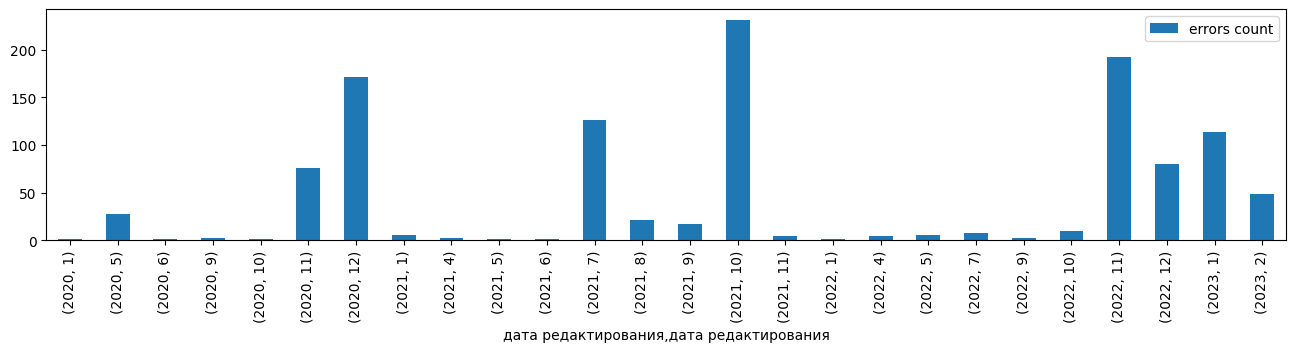

In [142]:
# userdocs.groupby(userdocs["–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è"].dt.year, userdocs["–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è"].dt.month) [['errors count','–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è']] .count().plot(kind="bar")
import matplotlib.pyplot as plt


ax = userdocs.groupby(
    [userdocs["–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è"].dt.year, userdocs["–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è"].dt.month ])[
        ['errors count']].count().plot(kind="bar", figsize=(16,3))

plt.show()

In [143]:
userdocsBak = userdocs.copy()

In [144]:
from collections import Counter


l = list(userdocs['vat_unit'].values) + list( userdocs['currency'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_currency=[]
for k in c:
    if c[k] < 2:
        rare_currency.append(k)
        

l = list(userdocs['–ü—Å–µ–≤–¥–æ–Ω–∏–º 1'].values) + list( userdocs['–ü—Å–µ–≤–¥–æ–Ω–∏–º 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_aliases=[]
for k in c:
    if c[k] < 2:
        rare_aliases.append(k)
# rare_aliases


l = list(userdocs['–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 1'].values) + list( userdocs['–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_forms=[]
for k in c:
    if c[k] < 2:
        rare_forms.append(k)
# print(rare_forms)        
        
    
    
for i, row in userdocs.iterrows():
    fs1 = str(row['–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 1']).lower()
    fs2 = str(row['–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2']).lower()
    
    as1 = str(row['–ü—Å–µ–≤–¥–æ–Ω–∏–º 1']).lower()
    as2 = str(row['–ü—Å–µ–≤–¥–æ–Ω–∏–º 2']).lower()
    
    
    cs1 = str(row['vat_unit']).lower()
    if cs1 in rare_currency:
        print(i, f'[{cs1}]')
        add_error(i, "–í–∞–ª—é—Ç–∞ –Ω–∞–ª–æ–≥–∞ –æ—á–µ–Ω—å —Å—Ç—Ä–∞–Ω–Ω–∞—è" )
        
    cs2 = str(row['currency']).lower()
    if cs2 in rare_currency:
        print(i, f'[{cs2}]')
        add_error(i, "–í–∞–ª—é—Ç–∞ –æ—á–µ–Ω—å —Å—Ç—Ä–∞–Ω–Ω–∞—è" )
    
    if fs1 in rare_forms:
        print(i, f'[{fs1}]')
        add_error(i, "–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 1 –æ—á–µ–Ω—å —Å—Ç—Ä–∞–Ω–Ω–∞—è" )
    if fs2 in rare_forms:
        print(i, f'[{fs2}]')
        add_error(i, "–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2 –æ—á–µ–Ω—å —Å—Ç—Ä–∞–Ω–Ω–∞—è" )
        
    if as1 in rare_aliases:
        print(i, f'[{as1}]')
        add_error(i, "–ü—Å–µ–≤–¥–æ–Ω–∏–º 1 –æ—á–µ–Ω—å —Å—Ç—Ä–∞–Ω–Ω—ã–π" )
    if as2 in rare_aliases:
        print(i, f'[{as2}]')
        add_error(i, "–ü—Å–µ–≤–¥–æ–Ω–∏–º 2 –æ—á–µ–Ω—å —Å—Ç—Ä–∞–Ω–Ω—ã–π" )
        
userdocs

5fe4821ab770574a00555656 [–æ–æ–æ ¬´]
612de89f4f22ff1b7e02fcd7 [eur]
5fb3d4a078df3635f5441c32 [–º—É–Ω–∏—Ü–∏–ø–∞–ª—å–Ω–æ–µ –∞–≤—Ç–æ–Ω–æ–º–Ω–æ–µ —É—á—Ä–µ–∂–¥–µ–Ω–∏–µ –∫—É–ª—å—Ç—É—Ä—ã]
6340244c9d08c565cfa12341 [¬´–∫—Ä–µ–¥–∏—Ç–æ—Ä¬ª]
6340244c9d08c565cfa12341 [¬´–∑–∞–µ–º—â–∏–∫¬ª]
6380855c6a07f3e980b2c061 [–æ–æ–æ ¬´—Ä–æ–º–∞—à–∫–∞¬ª]
5fdb2144542ce403c92b45c8 [—Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏–∞–ª—å–Ω–∞—è]
5fb3d79e78df3635f5441d1e [–æ–±—â–µ—Å—Ç–≤–æ —Å –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ–π –æ—Ç–≤–µ—Ç–µ –≤–µ–Ω–Ω–æ—Å—Ç—å—é]
5fe4821ab770574a00555657 [–æ–±—â–µ—Å—Ç–≤–µ–Ω–Ω–∞—è –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è ¬´—Å–ø–æ—Ä—Ç–∏–≤–Ω–∞—è –æ–±—â–µ—Å—Ç–≤–µ–Ω–Ω–∞—è –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è]
6380858a6a07f3e980b2c4aa [–∏—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å –∏–ª–∏ –ø–æ–¥—Ä—è–¥—á–∏–∫]
638085706a07f3e980b2c1ed [–∞–∫—Ü–∏–æ–Ω–µ—Ä–Ω–æ–µ –æ–±—â–µ—Å—Ç–≤–æ (–∞–æ )]
638085706a07f3e980b2c1f5 [–æ–±—â–µ—Å—Ç–≤–æ —Å –æ—Ç–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ–π –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç—å—é (–æ–æ–æ )]
5fca2aab9083b679224c75e7 [–≥–∞–∑–ø—Ä–æ–º–Ω–µ—Ñ—Ç—å-–æ—Ä–µ–Ω–±—É—Ä–≥]
62d149484ae369b4976e31ff [–

–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è  \
6152e5cc8558145da68d8797 2021-10-01 12:23:59.659   
6152e3af8558145da68d8790 2023-02-01 14:53:58.672   
6152e3798558145da68d8788 2021-09-30 08:13:06.705   
6285f525f098f73e14297f93 2022-10-25 11:16:59.890   
615ac8b28f3b0514f3f423f2 2021-10-04 09:27:25.636   
...                                          ...   
5fca2ab09083b679224c762b 2020-12-09 14:59:38.436   
6380856e6a07f3e980b2c1b5 2022-11-29 13:54:10.061   
5fca2aad9083b679224c7606 2020-12-09 15:05:30.896   
638085686a07f3e980b2c11f 2022-11-29 14:00:00.986   
6393256f1002115a6029f3f0 2023-02-04 08:05:50.469   

                                                                       link  \
6152e5cc8558145da68d8797  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6152e3af8558145da68d8790  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6152e3798558145da68d8788  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6285f525f098f73e14297f93  https://gpn-audit.nemosoft.ru/#/audit/edit/628...   
615ac8b28f3b0514f3f423f2  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
...                                                                     ...   
5fca2ab09083b679224c762b  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
6380856e6a07f3e980b2c1b5  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
5fca2aad9083b679224c7606  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
638085686a07f3e980b2c11f  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
6393256f1002115a6029f3f0  https://gpn-audit.nemosoft.ru/#/audit/edit/639...   

                                                                      error  \
6152e5cc8558145da68d8797                                                      
6152e3af8558145da68d8790     –Ω–∞–ª–æ–≥ –Ω–µ —É–∫–∞–∑–∞–Ω;\n–ù–æ–º–µ—Ä –Ω–µ —è–≤–ª—è–µ—Ç—Å—è –Ω–æ–º–µ—Ä–æ–º;\n   
6152e3798558145da68d8788                                                      
6285f525f098f73e14297f93  –ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 2: –∫–∞–≤—ã—á–∫–∞ –Ω–µ –∑–∞–∫—Ä—ã—Ç–∞;\n–ù–∞–∏–º–µ–Ω–æ–≤–∞...   
615ac8b28f3b0514f3f423f2                                                      
...                                                                     ...   
5fca2ab09083b679224c762b                                                      
6380856e6a07f3e980b2c1b5                                                      
5fca2aad9083b679224c7606                                                      
638085686a07f3e980b2c11f                                                      
6393256f1002115a6029f3f0                                                      

                                                              error missing  \
6152e5cc8558145da68d8797  –ü—Å–µ–≤–¥–æ–Ω–∏–º 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 2 –æ—Ç—Å—É—Ç—Å...   
6152e3af8558145da68d8790  –ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç...   
6152e3798558145da68d8788  –ü—Å–µ–≤–¥–æ–Ω–∏–º 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 2 –æ—Ç—Å—É—Ç—Å...   
6285f525f098f73e14297f93  –§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç...   
615ac8b28f3b0514f3f423f2  –ü—Å–µ–≤–¥–æ–Ω–∏–º 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n–§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2...   
...                                                                     ...   
5fca2ab09083b679224c762b                                                      
6380856e6a07f3e980b2c1b5                                                      
5fca2aad9083b679224c7606                                                      
638085686a07f3e980b2c11f                                                      
6393256f1002115a6029f3f0                                                      

                          errors count  subject len    subject kind  \
6152e5cc8558145da68d8797           6.0         76.0         Service   
6152e3af8558145da68d8790           6.0         56.0         Service   
6152e3798558145da68d8788           6.0         42.0         Servic

In [145]:

userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)     
# userdocs



In [146]:
userdocs_subj = userdocs[ ['subject kind', '–ü—Å–µ–≤–¥–æ–Ω–∏–º 1', '–ü—Å–µ–≤–¥–æ–Ω–∏–º 2']]
# userdocs_subj

def get_alias_pair(v):
    return ' -vs- '.join(   np.sort( list([ str(v['–ü—Å–µ–≤–¥–æ–Ω–∏–º 1']).lower(), str(v['–ü—Å–µ–≤–¥–æ–Ω–∏–º 2']).lower()])) ) 


 
c=Counter([get_alias_pair(v) for i, v in userdocs_subj.iterrows()])
rare_aliases_pairs=[k for k in c if c[k] < 2]
for i, row in userdocs.iterrows():
    d=get_alias_pair(row)
    if d in rare_aliases_pairs:
        print(i, f'[{d}]')
        userdocs.at[i, 'strange alias combo'] =f"–ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º–æ–≤: {d}"
        
print('-'*20)
del rare_aliases_pairs
# # rare_aliases_pairs
        
# del d
    
def get_alias_subject_pair(v, i):
    return ' / '.join(    list([ str(v[f'–ü—Å–µ–≤–¥–æ–Ω–∏–º {i}']).lower(), str(v['subject kind']).lower()])) 
    
p1 = [get_alias_subject_pair(v, 1) for i, v in userdocs_subj.iterrows()]


c=Counter(p1+[get_alias_subject_pair(v, 2) for i, v in userdocs_subj.iterrows()])
rare_alias_subj_pairs=[k for k in c if c[k] < 3]

for i, row in userdocs.iterrows():
    d1 = get_alias_subject_pair(row, 1)
    d2 = get_alias_subject_pair(row, 2)
    
    if d1 in rare_alias_subj_pairs:
        print(i, f'[{d1}]')
        userdocs.at[i, 'strange alias-subject'] =f"–ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º-–ø—Ä–µ–¥–º–µ—Ç: {d1}"
    
    if d2 in rare_alias_subj_pairs :
        print(i, f'[{d2}]')
        userdocs.at[i, 'strange alias-subject'] =f"–ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º-–ø—Ä–µ–¥–º–µ—Ç: {d2}"
        
print('-'*20)        
rare_alias_subj_pairs


612de89f4f22ff1b7e02fcd7 [nan -vs- –ø–æ–∫—É–ø–∞—Ç–µ–ª—å]
6340244c9d08c565cfa12341 [¬´–∑–∞–µ–º—â–∏–∫¬ª -vs- ¬´–∫—Ä–µ–¥–∏—Ç–æ—Ä¬ª]
62d149474ae369b4976e31fc [¬´–≥–µ–Ω–µ—Ä–∞–ª—å–Ω—ã–π –ø–æ–¥—Ä—è–¥—á–∏–∫¬ª -vs- ¬´–∑–∞—Å—Ç—Ä–æ–π—â–∏–∫¬ª]
638085766a07f3e980b2c280 [–∫–ª–∏–µ–Ω—Ç -vs- –ø–µ—Ä–µ–≤–æ–∑—á–∏–∫]
5fca2ab09083b679224c7638 [–∑–∞–∫–∞–∑–∏–∏ -vs- –∏—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å]
6380855c6a07f3e980b2c061 [–∫–ª—É–± -vs- –æ–æ–æ ¬´—Ä–æ–º–∞—à–∫–∞¬ª]
6294ae67df54d406a99b1631 [–≤–æ–¥–æ–ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å -vs- —É–ø–æ–ª–Ω–æ–º–æ—á–µ–Ω–Ω—ã–π –æ—Ä–≥–∞–Ω]
5ec2b8da665f7603e03b1255 [sun -vs- –≥–ø–Ω]
63a43056beaa9eeec65ecafb [nan -vs- –∑–∞–µ–º—â–∏–∫]
62c54895e599c73b751b7974 [nan -vs- –∫–ª—É–±]
63c506c9e2456d59975e1277 [–æ–æ–æ -vs- –ø—Ä–∞–≤–∏—Ç–µ–ª—å—Å—Ç–≤–æ]
635fa420bf4cb23cbb39282f [–∂–µ—Ä—Ç–≤–æ–≤–∞—Ç–µ–ª—å -vs- –∂–µ—Ä—Ç–≤–æ–ø–æ–ª—É—á–∞—Ç–µ–ª—å]
5fbbe46da2b4551c06107c68 [–ø–æ—Ç—Ä–µ–±–∏—Ç–µ–ª—å -vs- —Ç–µ–ø–ª–æ—Å–Ω–∞–±–∂–∞—é—â–∞—è –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è]
6380858a6a07f3e980b2c4aa [–∑–∞–∫–∞–∑—á–∏–∫ -vs- –∏—Å–ø–æ

['¬´–∫—Ä–µ–¥–∏—Ç–æ—Ä¬ª / loans',
 '¬´–∑–∞—Å—Ç—Ä–æ–π—â–∏–∫¬ª / generalcontract',
 '–∑–∞–∫–∞–∑–∏–∏ / service',
 '–æ–æ–æ ¬´—Ä–æ–º–∞—à–∫–∞¬ª / service',
 '–≤–æ–¥–æ–ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å / none',
 '–≥–ø–Ω / service',
 'nan / loans',
 'nan / other',
 '–æ–æ–æ / deal',
 '–ø–æ—Ç—Ä–µ–±–∏—Ç–µ–ª—å / deal',
 '–ø–æ—Å—Ç–∞–≤—â–∏–∫ / generalcontract',
 '—Å—Å—É–¥–æ–ø–æ–ª—É—á–∞—Ç–µ–ª—å / none',
 '—Å—Ç—Ä–∞—Ö–æ–≤–∞—Ç–µ–ª—å / none',
 '–ø—Ä–æ–¥–∞–≤–µ—Ü / loans',
 '—Å—Å—É–¥–æ–ø–æ–ª—É—á–∞—Ç–µ–ª—å / charity',
 '–ø–ª–∞—Ç–µ–ª—å—â–∏–∫ / charity',
 '–∑–∞—è–≤–∏—Ç–µ–ª—å / service',
 '—Å—Ç–æ—Ä–æ–Ω–∞ / service',
 '—Å—Ç–æ—Ä–æ–Ω–∞-1 / dealintellectualproperty',
 '–ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–µ / service',
 '–ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å / dealintellectualproperty',
 'nan / renting',
 '–∞—Ä–µ–Ω–¥–æ–¥–∞—Ç–µ–ª—å / none',
 '–ø–æ—Å—Ç–∞–≤—â–∏–∫ / realestate',
 '–∑–∞–∫–∞–∑—á–∏–∫ / renting',
 '–≥–µ–Ω–ø–æ–¥—Ä—è–¥—á–∏–∫ / service',
 '—ç–Ω–µ—Ä–≥–æ—Å–Ω–∞–±–∂–∞—é—â–∞—è –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è / service',
 '–ø–æ–¥—Ä—è–¥—á–∏–∫ / deal',
 '–∞–±–æ–Ω–

In [147]:
_s = f"#### {datetime.today().strftime('%d.%m.%Y')} *–í—Å–µ–≥–æ* –æ—à–∏–±–æ–∫, –Ω–µ–¥–æ—á–µ—Ç–æ–≤ –∏ –ø—Ä–æ—á.: {userdocs['errors count'].sum()} –≤ {len(userdocs)} –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö -- ({userdocs['errors count'].sum()/len(userdocs):0.2f} –Ω–∞ –¥–æ–∫—É–º–µ–Ω—Ç)"
display(Markdown(_s))

#### 06.02.2023 *–í—Å–µ–≥–æ* –æ—à–∏–±–æ–∫, –Ω–µ–¥–æ—á–µ—Ç–æ–≤ –∏ –ø—Ä–æ—á.: 1433.0 –≤ 1154 –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö -- (1.24 –Ω–∞ –¥–æ–∫—É–º–µ–Ω—Ç)

In [148]:
userdocs_subj = userdocs[ ['link','subject kind', '–ü—Å–µ–≤–¥–æ–Ω–∏–º 1', '–ü—Å–µ–≤–¥–æ–Ω–∏–º 2', 'strange alias combo', 'strange alias-subject' ]]

errors_subjects = userdocs_subj[userdocs_subj['strange alias combo'].notnull() | userdocs_subj['strange alias-subject'].notnull() ]
errors_subjects.to_csv("errors_subjects.csv", index=True)         
errors_subjects

link  \
612de89f4f22ff1b7e02fcd7  https://gpn-audit.nemosoft.ru/#/audit/edit/612...   
6340244c9d08c565cfa12341  https://gpn-audit.nemosoft.ru/#/audit/edit/634...   
62d149474ae369b4976e31fc  https://gpn-audit.nemosoft.ru/#/audit/edit/62d...   
638085766a07f3e980b2c280  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
5fca2ab09083b679224c7638  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
...                                                                     ...   
5fbbe46da2b4551c06107c8d  https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...   
63be916f6ba909ce9c6bfe5b  https://gpn-audit.nemosoft.ru/#/audit/edit/63b...   
5fdb2145542ce403c92b45fc  https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...   
5fc63d611d0a1603c7a0c97d  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
617269de8fd5658689eb2bca  https://gpn-audit.nemosoft.ru/#/audit/edit/617...   

                                      subject kind     –ü—Å–µ–≤–¥–æ–Ω–∏–º 1  \
612de89f4f22ff1b7e02fcd7                      Deal      –ü–û–ö–£–ü–ê–¢–ï–õ–¨   
6340244c9d08c565cfa12341                     Loans      ¬´–ö—Ä–µ–¥–∏—Ç–æ—Ä¬ª   
62d149474ae369b4976e31fc           GeneralContract    ¬´–ó–∞—Å—Ç—Ä–æ–π—â–∏–∫¬ª   
638085766a07f3e980b2c280                   Service          –ö–ª–∏–µ–Ω—Ç   
5fca2ab09083b679224c7638                   Service         –ó–∞–∫–∞–∑–∏–∏   
...                                            ...             ...   
5fbbe46da2b4551c06107c8d  DealIntellectualProperty         –ê–±–æ–Ω–µ–Ω—Ç   
63be916f6ba909ce9c6bfe5b            BankGuarantees          –ö–ª–∏–µ–Ω—Ç   
5fdb2145542ce403c92b45fc                   Service          –ö–ª–∏–µ–Ω—Ç   
5fc63d611d0a1603c7a0c97d                      Deal  –ë–ª–∞–≥–æ—Ç–≤–æ—Ä–∏—Ç–µ–ª—å   
617269de8fd5658689eb2bca            BankGuarantees       –ó–∞—è–≤–∏—Ç–µ–ª—å   

                                      –ü—Å–µ–≤–¥–æ–Ω–∏–º 2  \
612de89f4f22ff1b7e02fcd7                      NaN   
6340244c9d08c565cfa12341                ¬´–ó–∞–µ–º—â–∏–∫¬ª   
62d149474ae369b4976e31fc  ¬´–ì–µ–Ω–µ—Ä–∞–ª—å–Ω—ã–π –ø–æ–¥—Ä—è–¥—á–∏–∫¬ª   
638085766a07f3e980b2c280               –ü–µ—Ä–µ–≤–æ–∑—á–∏–∫   
5fca2ab09083b679224c7638              –ò—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å   
...                                           ...   
5fbbe46da2b4551c06107c8d                –ü–æ—Å—Ç–∞–≤—â–∏–∫   
63be916f6ba909ce9c6bfe5b                     –ë–∞–Ω–∫   
5fdb2145542ce403c92b45fc              –ò—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å   
5fc63d611d0a1603c7a0c97d          –ë–ª–∞–≥–æ–ø–æ–ª—É—á–∞—Ç–µ–ª—å   
617269de8fd5658689eb2bca                     –ë–∞–Ω–∫   

                                                        strange alias combo  \
612de89f4f22ff1b7e02fcd7    –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º–æ–≤: nan -vs- –ø–æ–∫—É–ø–∞—Ç–µ–ª—å   
6340244c9d08c565cfa12341  –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º–æ–≤: ¬´–∑–∞–µ–º—â–∏–∫¬ª -vs- ¬´–∫—Ä...   
62d149474ae369b4976e31fc  –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º–æ–≤: ¬´–≥–µ–Ω–µ—Ä–∞–ª—å–Ω—ã–π –ø–æ–¥—Ä—è...   
638085766a07f3e980b2c280  –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º–æ–≤: –∫–ª–∏–µ–Ω—Ç -vs- –ø–µ—Ä–µ–≤–æ...   
5fca2ab09083b679224c7638  –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º–æ–≤: –∑–∞–∫–∞–∑–∏–∏ -vs- –∏—Å–ø–æ–ª...   
...                                                                     ...   
5fbbe46da2b4551c06107c8d                                                NaN   
63be916f6ba909ce9c6bfe5b                                                NaN   
5fdb2145542ce403c92b45fc  –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º–æ–≤: –∏—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å -vs- –∫...   
5fc63d611d0a1603c7a0c97d                                                NaN   
617269de8fd5658689eb2bca                                                NaN   

                                                      strange alias-subject  
612de89f4f22ff1b7e02fcd7       –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º-–ø—Ä–µ–¥–º–µ—Ç: nan / deal  
6340244c9d08c565cfa12341  –ù–µ–æ–±—ã—á–Ω–∞—è –ø–∞—Ä–∞ –ø—Å–µ–≤–¥–æ–Ω–∏–º-–ø—Ä–µ–¥–º–µ—Ç: ¬´

In [153]:
userdocs[userdocs['errors count']<2]

–¥–∞—Ç–∞ —Ä–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è  \
5fca2abe9083b679224c76aa 2020-12-10 09:03:55.360   
5fbf75c75d05d73d0295fac0 2020-11-26 12:16:53.044   
5fbbe46da2b4551c06107c93 2020-11-24 07:59:01.301   
5fb674f833c72547b754ff6c 2021-10-29 12:22:33.613   
5fca2aac9083b679224c7605 2020-12-10 09:02:08.201   
...                                          ...   
6167d79187f1d9065bb8b94b 2021-10-14 07:21:37.988   
5fdb213e542ce403c92b4523 2020-12-18 09:37:15.277   
6166de2a87f1d9065bb8b93b 2021-10-13 13:31:51.249   
5fdb213e542ce403c92b4521 2020-12-18 09:37:43.148   
6393256f1002115a6029f3f0 2023-02-04 08:05:50.469   

                                                                       link  \
5fca2abe9083b679224c76aa  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
5fbf75c75d05d73d0295fac0  https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...   
5fbbe46da2b4551c06107c93  https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...   
5fb674f833c72547b754ff6c  https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...   
5fca2aac9083b679224c7605  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
...                                                                     ...   
6167d79187f1d9065bb8b94b  https://gpn-audit.nemosoft.ru/#/audit/edit/616...   
5fdb213e542ce403c92b4523  https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...   
6166de2a87f1d9065bb8b93b  https://gpn-audit.nemosoft.ru/#/audit/edit/616...   
5fdb213e542ce403c92b4521  https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...   
6393256f1002115a6029f3f0  https://gpn-audit.nemosoft.ru/#/audit/edit/639...   

                                                          error  \
5fca2abe9083b679224c76aa                     –Ω–∞–ª–æ–≥ –Ω–µ —É–∫–∞–∑–∞–Ω;\n   
5fbf75c75d05d73d0295fac0                     –Ω–∞–ª–æ–≥ –Ω–µ —É–∫–∞–∑–∞–Ω;\n   
5fbbe46da2b4551c06107c93  –ù–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ 1: –∫–∞–≤—ã—á–∫–∞ –Ω–µ –∑–∞–∫—Ä—ã—Ç–∞;\n   
5fb674f833c72547b754ff6c                                          
5fca2aac9083b679224c7605                –î–∞—Ç–∞ —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–∞—è;\n   
...                                                         ...   
6167d79187f1d9065bb8b94b                                          
5fdb213e542ce403c92b4523                                          
6166de2a87f1d9065bb8b93b                                          
5fdb213e542ce403c92b4521                                          
6393256f1002115a6029f3f0                                          

                                                error missing  errors count  \
5fca2abe9083b679224c76aa                                                1.0   
5fbf75c75d05d73d0295fac0                                                1.0   
5fbbe46da2b4551c06107c93                                                1.0   
5fb674f833c72547b754ff6c  –§–æ—Ä–º–∞ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç–∏ 2 –æ—Ç—Å—É—Ç—Å–≤—É–µ—Ç;\n           1.0   
5fca2aac9083b679224c7605                                                1.0   
...                                                       ...           ...   
6167d79187f1d9065bb8b94b                                                0.0   
5fdb213e542ce403c92b4523                                                0.0   
6166de2a87f1d9065bb8b93b                                                0.0   
5fdb213e542ce403c92b4521                                                0.0   
6393256f1002115a6029f3f0                                                0.0   

                          subject len                       subject kind  \
5fca2abe9083b679224c76aa         39.0                            Service   
5fbf75c75d05d73d0295fac0         31.0                    GeneralContract   
5fbbe46da2b4551c06107c93         94.0                               Deal   
5fb674f833c72547b754ff6c         54.0                            Renting   
5fca2aac9083b679224c7605         86.0  ParticipationInOtherOrganizations   
...                               ...                                ...   
6167d79187f1d9065bb8b94b         26.0              

# Make datapoints

In [115]:
work_dir

PosixPath('/root/artem/work')

In [116]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [117]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set




80

### Trainset fixtures
#### Invalidate long subjects

In [118]:
ids = list(dups_s.index)


ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len            
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


3008 63ce4a28e83d1ee490f3f4b2 [0, 200] 200
–ü–†–ò–õ–û–ñ–ï–ù–ò–ï ‚Ññ 4 –ö –ö–û–ù–¢–†–ê–ö–¢–£ ‚Ññ –æ—Ç ANNEX No. 4. –∏ TO 
3042 63ce4a83e83d1ee490f3f9eb [0, 200] 200
–ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ ‚Ññ 7 –∫ –¥–æ–≥–æ–≤–æ—Ä—É ‚Ññ –æ—Ç" "2019 –≥–æ–¥–∞

3063 63ce4b0ee83d1ee490f400d1 [0, 200] 200
–ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ ‚Ññ 1 –æ—Ç 29-04-2021 –≥–æ–¥.



#### Fix missing headers

In [119]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k,oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


In [120]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [121]:
len(ids_of_long_subject_docs)

3

In [122]:
dups_s

source                          checksum    version  \
_id                                                                            
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d      3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
...                         ...                               ...        ...   
5fb2796dd8c9df1ed1236da1     db  b733e0ee7d949178ac45254c1d20318b      2.4.4   
5fb376e7d8c9df1ed1237344     db  3d0fea955ac3bd7a07c96d0f68a8b491      2.5.3   
5fb27c60d8c9df1ed1236ebb     db  a77061e7f6ae850a1c5b0f2d12b9fff3      2.4.4   
5fb27c60d8c9df1ed1236eaa     db  b7f385658967abd6d46f4ca18d90635d      2.4.4   
5fb6750733c72547b75500b4     db  55c963405158b197ebb3a323a4f60b7d      2.4.4   

                                         export_date     len  \
_id                                                            
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517  6740.0   
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394  5840.0   
5edbc62eda3678279fbcadf3  2023-02-05 13:09:05.381133  1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-05 13:09:01.777643   460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376  8530.0   
...                                              ...     ...   
5fb2796dd8c9df1ed1236da1  2023-01-31 18:37:43.648610   130.0   
5fb376e7d8c9df1ed1237344  2023-01-31 18:37:59.243967   210.0   
5fb27c60d8c9df1ed1236ebb  2023-01-31 18:37:43.782338   120.0   
5fb27c60d8c9df1ed1236eaa  2023-01-31 18:37:43.778611    80.0   
5fb6750733c72547b75500b4  2023-01-31 18:37:44.137656   200.0   

                                             analyze_date         value  \
_id                                                                       
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
...                                                   ...           ...   
5fb2796dd8c9df1ed1236da1 2021-07-23 10:20:47.637000+00:00           NaN   
5fb376e7d8c9df1ed1237344 2021-10-28 15:52:29.224000+00:00           NaN   
5fb27c60d8c9df1ed1236ebb 2021-07-23 10:32:28.793000+00:00           NaN   
5fb27c60d8c9df1ed1236eaa 2021-07-23 10:31:50.517000+00:00           NaN   
5fb6750733c72547b75500b4 2021-07-28 18:15:18.696000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...   
...                               ...         ...      ...  ...   
5fb2796dd8c9df1ed1236da1          NaN         NaN      NaN  ...   
5fb376e7d8c9df1ed1237344          NaN         NaN      NaN  ...   
5fb27c60d8c9df1ed1236ebb          NaN         NaN      NaN  ...   
5fb27c60d8c9df1ed1236eaa          NaN         NaN      NaN  ...   
5fb6750733c72547b75500b4          NaN         NaN      NaN  ...   

                                     user_correction_date  valid documentType  \
_id                                                                             
6340244c9d08c565cfa12341 2022-10-07 13:43:21.470000+00:00   True    AGREEMENT   
5ec2b8da665f7603e03b1255 2023-01-27 10:27:22.086000+00:00   

In [123]:
stats.to_csv(export_fn, index=True)

In [ ]:


for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


In [ ]:
25